# SAM_demo Notebook

## Table of Contents
- [1. Data Loading and Preprocessing](#Data-Loading-and-Preprocessing)
- [2. Simulator Functions](#Simulator-Functions)
- [3. Scoring Calculations](#Scoring-Calculations)
- [4. Visualization](#Visualization)
- [5. Testing and Results Analysis](#Testing-and-Results-Analysis)

<h2 id="data-loading-and-preprocessing">1. Data Loading and Preprocessing</h2>

In [12]:
# Imports
from itertools import combinations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
sys.path.insert(0, os.path.abspath('..'))
from tools import generate_structured_gaussian_basis_functions, simulate_sensor_output, compute_distance_matrix, \
    spectral_angle_mapper, visualize_distance_matrix, visualize_sensor_output, group_based_dissimilarity_score, \
    min_based_dissimilarity_score


Substances spectral data shape: (142, 5)
Emissivity curves shape: (142, 4)
Gaussian Basis Functions Shape: (142, 165)
Original basis functions shape: (142, 7)
Generated Gaussian basis functions shape: (142, 165)


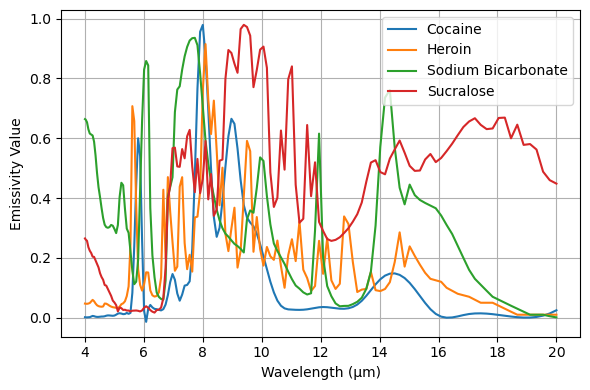

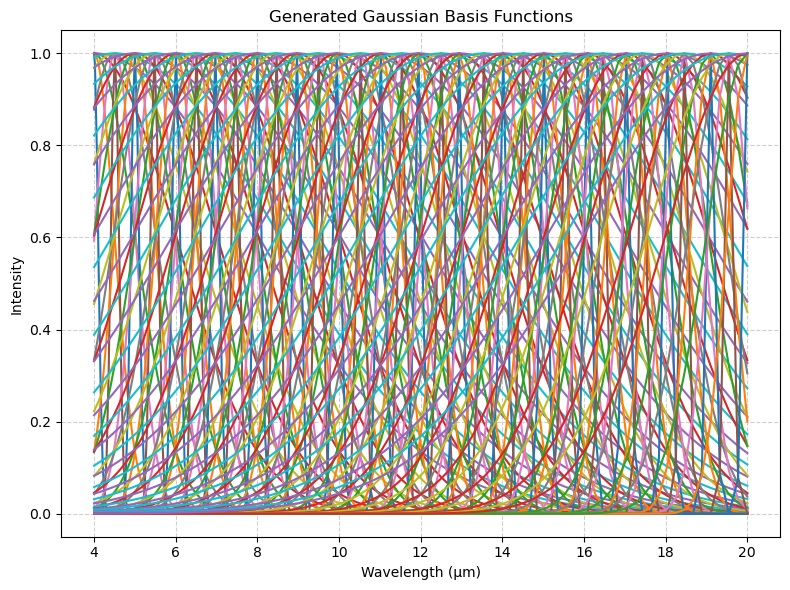

In [13]:
# Load substances and generate basis functions

# --------------------------------------------------------------------------------------------------
# File Locations
# --------------------------------------------------------------------------------------------------

# File paths for input data
spectral_data_file = '../data/Test 3 - 4 White Powers/white_powders_with_labels.xlsx'
air_transmittance_file = '../data/Test 3 - 4 White Powers/Air transmittance.xlsx'
basis_functions_file = '../data/Test 3 - 4 White Powers/Basis functions_4-20um.xlsx'

# --------------------------------------------------------------------------------------------------
# Configurable Parameters
# --------------------------------------------------------------------------------------------------

atmospheric_distance_ratio = 0.11  # Used to model the effect of atmospheric conditions on measurements
temperature_K = 293.15  # Temperature in Kelvin
air_refractive_index = 1  # Refractive index of air

# --------------------------------------------------------------------------------------------------
# Loading Spectral Data & Extracting Features
# --------------------------------------------------------------------------------------------------

# Load the spectral data of substances
substances_spectral_data = pd.read_excel(spectral_data_file)

# Verify the dimensions of the loaded data
print("Substances spectral data shape:", substances_spectral_data.shape)

# Extract the wavelength values (first column)
wavelengths = substances_spectral_data.iloc[:, :1]  # Shape = (d, 1)
# print(wavelengths.iloc[:, 0].tolist())

# Extract substance labels (column names excluding the first)
substance_names = substances_spectral_data.columns[1:].to_numpy()

# Extract emissivity curves (all data except the first column)
emissivity_curves = substances_spectral_data.iloc[:, 1:].to_numpy()
print("Emissivity curves shape:", emissivity_curves.shape)

# --------------------------------------------------------------------------------------------------
# Loading Basis Functions
# --------------------------------------------------------------------------------------------------

# Load the original basis functions from file (provided by Data Design Team)
original_basis_functions = np.array(pd.read_excel(basis_functions_file, header=None))
original_basis_functions = original_basis_functions[:, 1:]  # Remove the spectra column

# # Generate 50 Gaussian-based Basis Functions for testing
# num_basis_functions = 50  # Number of basis functions to generate
# random_seed = 323          # Set random seed for reproducibility
# gaussian_basis_functions, means, sigmas = generate_gaussian_basis_functions(
#     wavelengths, 
#     num_basis_functions, 
#     random_seed=random_seed
# )

# Parameters for Structured Gaussian Basis Functions
mean_range = (4, 20)  # Range for the means
# step = 0.5
# widths = [0.1, 0.5, 1.0, 2.0, 3.0]  # Widths for thin, medium, fat, and fattest

step = 0.5
widths = [0.1, 0.5, 1.0, 2.0, 4.0]  # Widths for thin, medium, fat, and fattest

# Generate Gaussian basis functions using the updated function
gaussian_basis_functions, all_means, all_sigmas = generate_structured_gaussian_basis_functions(
    wavelengths=wavelengths,
    mean_range=mean_range,
    step=step,
    widths=widths
)

# Verify outputs
print("Gaussian Basis Functions Shape:", gaussian_basis_functions.shape)  # Should be (len(wavelengths), num_basis_functions)
# print("Means:", all_means)  # Shape (num_basis_functions,)
# print("Sigmas:", all_sigmas)  # Shape (num_basis_functions,)


# Verify the shapes of the loaded and generated basis functions
print("Original basis functions shape:", original_basis_functions.shape)
print("Generated Gaussian basis functions shape:", gaussian_basis_functions.shape)

# --------------------------------------------------------------------------------------------------
# Loading Additional Parameters
# --------------------------------------------------------------------------------------------------

# Load air transmittance matrix
air_transmittance = np.array(pd.read_excel(air_transmittance_file, header=None))
air_transmittance = air_transmittance[:, 1:]  # Remove the spectra column

# --------------------------------------------------------------------------------------------------
# Visualization: Spectral Emissivity Curves
# --------------------------------------------------------------------------------------------------

# Plot the emissivity curves for all substances
plt.figure(figsize=(6, 4))  
for name in substance_names:
    plt.plot(wavelengths, substances_spectral_data[name], label=name)

# Add plot labels and grid
plt.xlabel('Wavelength (µm)')
plt.ylabel('Emissivity Value')
# plt.title('Spectral Emissivity Curves of Substances')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------------------------------
# Visualization: Gaussian Basis Functions
# --------------------------------------------------------------------------------------------------

# Plot the Gaussian basis functions
plt.figure(figsize=(8, 6))

max_to_plot = 300  # Plot only the first 10 functions for clarity
for i in range(min(max_to_plot, gaussian_basis_functions.shape[1])):
    # Plot each Gaussian basis function with its mean and sigma values
    plt.plot(wavelengths, gaussian_basis_functions[:, i], label=f"µ={all_means[i]:.1f}, σ={all_sigmas[i]:.1f}")

# Customize plot aesthetics
plt.xlabel("Wavelength (µm)")
plt.ylabel("Intensity")
plt.title("Generated Gaussian Basis Functions")
# plt.legend(fontsize=8, loc="upper right")  # Uncomment to add legends for each function
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

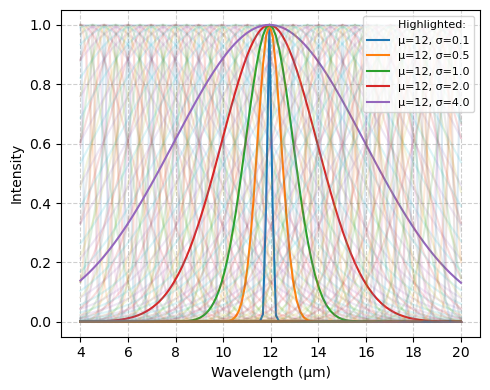

In [14]:
# Plot for better visualization

import matplotlib.pyplot as plt
import numpy as np

# Find the center wavelength dynamically from all_means
center_wavelength = min(all_means, key=lambda x: abs(x - 12))  # Closest mean to 12 µm

# Create figure
plt.figure(figsize=(5, 4))

legend_handles = []  # Store handles for legend
legend_labels = []   # Store labels for legend

# Loop through basis functions and adjust alpha based on their mean
for i in range(gaussian_basis_functions.shape[1]):
    alpha_value = 1.0 if abs(all_means[i] - center_wavelength) < 0.01 else 0.15  # Full color if closest to 12 µm
    line, = plt.plot(wavelengths, gaussian_basis_functions[:, i], alpha=alpha_value)

    # Store only the highlighted functions in the legend
    if alpha_value == 1.0:
        legend_handles.append(line)
        legend_labels.append(f"µ={all_means[i]:.0f}, σ={all_sigmas[i]:.1f}")

# Add a general label for the highlighted curves
if legend_handles:
    legend_labels.insert(0, "Highlighted: ")  # Insert at the beginning
    legend_handles.insert(0, plt.Line2D([0], [0], color="black", linestyle=""))  # Invisible marker for label spacing

# Customize plot
plt.xlabel("Wavelength (µm)")
plt.ylabel("Intensity")
plt.grid(True, linestyle="--", alpha=0.6)

# Add legend only for the highlighted basis functions
if legend_handles:
    plt.legend(legend_handles, legend_labels, fontsize=8, loc="upper right")

plt.tight_layout()

# Show plot
plt.show()

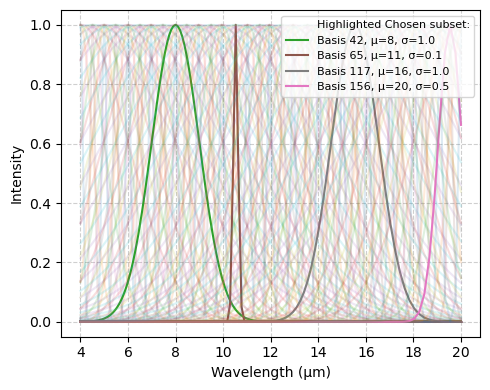

In [15]:
# Plot for better visualization with specific highlighted basis functions

import matplotlib.pyplot as plt
import numpy as np

# Define the indices of the four basis functions to highlight
highlighted_indices = [42, 65, 117, 156]

# Create figure
plt.figure(figsize=(5, 4))

legend_handles = []  # Store handles for legend
legend_labels = []   # Store labels for legend

# Loop through all basis functions
for i in range(gaussian_basis_functions.shape[1]):
    # Highlight selected indices, dim the rest
    alpha_value = 1.0 if i in highlighted_indices else 0.15  
    line, = plt.plot(wavelengths, gaussian_basis_functions[:, i], alpha=alpha_value)

    # Store highlighted basis functions in the legend
    if i in highlighted_indices:
        legend_handles.append(line)
        legend_labels.append(f"Basis {i}, µ={all_means[i]:.0f}, σ={all_sigmas[i]:.1f}")

# Add general label for highlighted basis functions
if legend_handles:
    legend_labels.insert(0, "Highlighted Chosen subset:")  # Insert at the beginning
    legend_handles.insert(0, plt.Line2D([0], [0], color="black", linestyle=""))  # Invisible marker for spacing

# Customize plot
plt.xlabel("Wavelength (µm)")
plt.ylabel("Intensity")
plt.grid(True, linestyle="--", alpha=0.6)

# Add legend only for the highlighted basis functions
if legend_handles:
    plt.legend(legend_handles, legend_labels, fontsize=8, loc="upper right")

plt.tight_layout()

# Show plot
plt.show()

In [16]:
# # Unnecessary plots

# # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# # This section is some quick test done on a simulated sensor build with all basis function. 
# # I don't know if I want to keep it since it might not be much meaningful.
# # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# # --------------------------------------------------------------------------------------------------
# # Generate Sensor Outputs
# # --------------------------------------------------------------------------------------------------

# # Generate the sensor response matrix using the selected basis functions and emissivity curves
# sensor_outputs = simulate_sensor_output(
#     wavelengths=wavelengths,  # Wavelength data
#     substances_emissivity=emissivity_curves,  # Emissivity curves of substances
#     basis_functions=gaussian_basis_functions,  # Selected basis functions
#     temperature_K=temperature_K,  # Temperature in Kelvin
#     atmospheric_distance_ratio=atmospheric_distance_ratio,  # Atmospheric distance ratio
#     air_refractive_index=air_refractive_index,  # Refractive index of air
#     air_transmittance=air_transmittance  # Air transmittance matrix
# )

# # Verify the shape of the sensor outputs
# print("Sensor outputs shape:", sensor_outputs.shape)

# # --------------------------------------------------------------------------------------------------
# # Compute SAM Distance Matrix
# # --------------------------------------------------------------------------------------------------

# # Compute the Spectral Angle Mapper (SAM) distance matrix
# distance_matrix = compute_distance_matrix(sensor_outputs, spectral_angle_mapper)

# # Visualize the distance matrix
# visualize_distance_matrix(
#     distance_matrix,
#     labels=substance_names,  # Labels for substances
#     title="Distance Matrix (SAM)"  # Title of the plot
# )

# # --------------------------------------------------------------------------------------------------
# # Compute and Visualize Basis Function Similarity Matrix
# # --------------------------------------------------------------------------------------------------

# from sklearn.metrics.pairwise import cosine_similarity
# from scipy.cluster.hierarchy import linkage, leaves_list
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Step 1: Compute the similarity matrix for basis functions
# basis_function_similarity = cosine_similarity(gaussian_basis_functions.T)  # Transpose for pairwise similarity

# # Step 2: Perform hierarchical clustering and reorder the similarity matrix
# linkage_matrix = linkage(basis_function_similarity, method='average')  # Hierarchical clustering
# sorted_indices = leaves_list(linkage_matrix)  # Extract reordered indices
# sorted_similarity_matrix = basis_function_similarity[sorted_indices, :][:, sorted_indices]  # Reorder the similarity matrix

# # Step 3: Visualize the grouped similarity matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(sorted_similarity_matrix, cmap="viridis", cbar=True)
# plt.title("Grouped Basis Function Similarity Matrix", fontsize=14, fontweight="bold")
# plt.xlabel("Basis Function Index (Grouped)")
# plt.ylabel("Basis Function Index (Grouped)")
# plt.tight_layout()
# plt.show()

# # --------------------------------------------------------------------------------------------------
# # Visualization: Sensor Output
# # --------------------------------------------------------------------------------------------------

# # Reorder the sensor outputs based on the sorted indices from clustering
# sensor_outputs_sorted = sensor_outputs[sorted_indices, :]  # Reorder rows (basis functions)

# # Visualize the reordered sensor outputs
# visualize_sensor_output(
#     sensor_outputs_sorted,
#     substances_names=substance_names,  # Labels for substances
#     # Optionally update basis function labels if needed
#     # basis_funcs_labels=[f"{i+1}" for i in sorted_indices]  # Updated labels (optional)
# )

In [17]:
# # Unnecessary calculations

# # --------------------------------------------------------------------------------------------------
# # Compute Mean-Min Based Dissimilarity Score
# # --------------------------------------------------------------------------------------------------

# # Compute the mean-min based dissimilarity score with a specified alpha
# mean_min_score = mean_min_based_dissimilarity_score(distance_matrix, alpha=3)

# # Display the computed score
# print("Mean-Min Based Dissimilarity Score:", mean_min_score)

# # --------------------------------------------------------------------------------------------------
# # Compute Group-Based Dissimilarity Score
# # --------------------------------------------------------------------------------------------------

# # Define the groups for dissimilarity evaluation
# groups = [
#     [0, 2],  # Group 1: Cocaine, Heroin
#     [1, 3]   # Group 2: Sodium Bicarbonate, Sucralose
# ]

# # Compute the group-based dissimilarity score
# group_based_score = group_based_dissimilarity_score(distance_matrix, groups)

# # Display the computed score
# print("Group-Based Dissimilarity Score:", group_based_score)

In [18]:
# # Original sensor output and distance matrix calculation

# # --------------------------------------------------------------------------------------------------
# # Configuration: Number of Basis Functions to Select
# # --------------------------------------------------------------------------------------------------

# # Define the number of basis functions to select for evaluation
# num_basis_funcs = 4

# # Generate all possible combinations of the specified number of basis functions
# basis_func_combinations = list(combinations(range(gaussian_basis_functions.shape[1]), num_basis_funcs))

# # --------------------------------------------------------------------------------------------------
# # Compute Scores for Each Subset of Basis Functions
# # --------------------------------------------------------------------------------------------------

# # Initialize a list to store results
# results = []

# # Iterate through each combination of basis functions
# for subset in basis_func_combinations:
#     # Select the current subset of basis functions
#     selected_basis_funcs = gaussian_basis_functions[:, subset]

#     # Generate sensor outputs for the selected basis functions
#     sensor_outputs = simulate_sensor_output(
#         wavelengths=wavelengths,
#         substances_emissivity=emissivity_curves,
#         basis_functions=selected_basis_funcs,
#         temperature_K=temperature_K,
#         atmospheric_distance_ratio=atmospheric_distance_ratio,
#         air_refractive_index=air_refractive_index,
#         air_transmittance=air_transmittance
#     )

#     # Compute the distance matrix using the SAM metric
#     distance_matrix = compute_distance_matrix(sensor_outputs, spectral_angle_mapper)

#     # Compute scores for the current subset
#     score_mean_min = mean_min_based_dissimilarity_score(distance_matrix, alpha=3)
#     score_group_based = group_based_dissimilarity_score(distance_matrix, groups)

#     # Store the subset and scores in the results
#     results.append({
#         "subset": subset,
#         "mean_min_score": score_mean_min,
#         "group_based_score": score_group_based
#     })

# # --------------------------------------------------------------------------------------------------
# # Analyze and Display the Best Results
# # --------------------------------------------------------------------------------------------------

# # Convert the results into a DataFrame for easier analysis
# results_df = pd.DataFrame(results)

# # Identify the best subset for mean-min score
# best_result_mean_min = results_df.sort_values(by="mean_min_score", ascending=False).iloc[0]
# print("Best Subset (Mean-Min Score):", best_result_mean_min["subset"])
# print("Best Mean-Min Score:", best_result_mean_min["mean_min_score"])

# # Identify the best subset for group-based score
# best_result_group_based = results_df.sort_values(by="group_based_score", ascending=False).iloc[0]
# print("Best Subset (Group-Based Score):", best_result_group_based["subset"])
# print("Best Group-Based Score:", best_result_group_based["group_based_score"])

In [19]:
# Updated sensor output and distance matrix calculation - multiprocessing

import functools
from concurrent.futures import ProcessPoolExecutor
from tqdm.notebook import tqdm
from multiprocessing_helpers import process_subset

# --------------------------------------------------------------------------------------------------
# Configuration: Number of Basis Functions to Select
# --------------------------------------------------------------------------------------------------

# Define the number of basis functions to select for evaluation
num_basis_funcs = 4

# Generate all possible combinations of the specified number of basis functions
basis_func_combinations = list(combinations(range(gaussian_basis_functions.shape[1]), num_basis_funcs))
print(f"Total combinations: {len(basis_func_combinations)}")

# Define the groups for dissimilarity evaluation
groups = [
    [0, 1],  # Group 1: Cocaine, Heroin
    [2, 3]   # Group 2: Sodium Bicarbonate, Sucralose
]

# --------------------------------------------------------------------------------------------------
# Parallel Processing: Compute Scores for Each Subset of Basis Functions
# --------------------------------------------------------------------------------------------------

# Prepare a partial function to bind additional arguments for the processing function
process_subset_partial = functools.partial(
    process_subset,
    gaussian_basis_functions=gaussian_basis_functions,
    wavelengths=wavelengths,
    emissivity_curves=emissivity_curves,
    temperature_K=temperature_K,
    atmospheric_distance_ratio=atmospheric_distance_ratio,
    air_refractive_index=air_refractive_index,
    air_transmittance=air_transmittance,
    spectral_angle_mapper=spectral_angle_mapper,
    groups=groups
)

# Use a process pool for parallel processing of basis function combinations
results = []
with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
    # Submit tasks in parallel using the partial function and display progress using tqdm
    futures = list(tqdm(
        executor.map(process_subset_partial, basis_func_combinations, chunksize=100),
        total=len(basis_func_combinations),
        desc="Processing Combinations"
    ))

    # Collect results from completed tasks
    results = [res for res in futures if res is not None]


# Convert the results into a DataFrame for easier analysis and sorting
results_df = pd.DataFrame(results)

Total combinations: 29772765


Processing Combinations:   0%|          | 0/29772765 [00:00<?, ?it/s]

In [20]:
# Analyze and Sort Results
# --------------------------------------------------------------------------------------------------

# Sort and save the DataFrame based on different scores for future use
results_sorted_min = results_df.sort_values(by="min_score", ascending=False).reset_index(drop=True)
# results_sorted_mean_min = results_df.sort_values(by="mean_min_score", ascending=False).reset_index(drop=True)
results_sorted_group_based = results_df.sort_values(by="group_based_score", ascending=False).reset_index(drop=True)
# results_sorted_weighted_mean_min = results_df.sort_values(by="weighted_mean_min_score", ascending=False)
# results_sorted_fom = results_df.sort_values(by="fom_score", ascending=True)

# Identify and print the best subset for each metric
best_result_min = results_sorted_min.iloc[0]
# best_result_mean_min = results_sorted_mean_min.iloc[0]
best_result_group_based = results_sorted_group_based.iloc[0]
# best_result_weighted_mean_min = results_sorted_weighted_mean_min.iloc[0]
# best_result_fom = results_sorted_fom.iloc[0]

print("Best Subset (Min Score):", best_result_min["basis_function_indices"])
print("Best Min Score:", best_result_min["min_score"])

# print("Best Subset (Mean-Min Score):", best_result_mean_min["basis_function_indices"])
# print("Best Mean-Min Score:", best_result_mean_min["mean_min_score"])

print("Best Subset (Group-Based Score):", best_result_group_based["basis_function_indices"])
print("Best Group-Based Score:", best_result_group_based["group_based_score"])

# print("Best Subset (Weighted Mean-Min Score):", best_result_weighted_mean_min["basis_function_indices"])
# print("Best Weighted Mean-Min Score:", best_result_weighted_mean_min["weighted_mean_min_score"])

# print("Best Subset (FOM Score):", best_result_fom["basis_function_indices"])
# print("Best FOM Score:", best_result_fom["fom_score"])

Best Subset (Min Score): (90, 95, 120, 156)
Best Min Score: 47.415745003512654
Best Subset (Group-Based Score): (1, 5, 25, 150)
Best Group-Based Score: 71.96578710986319


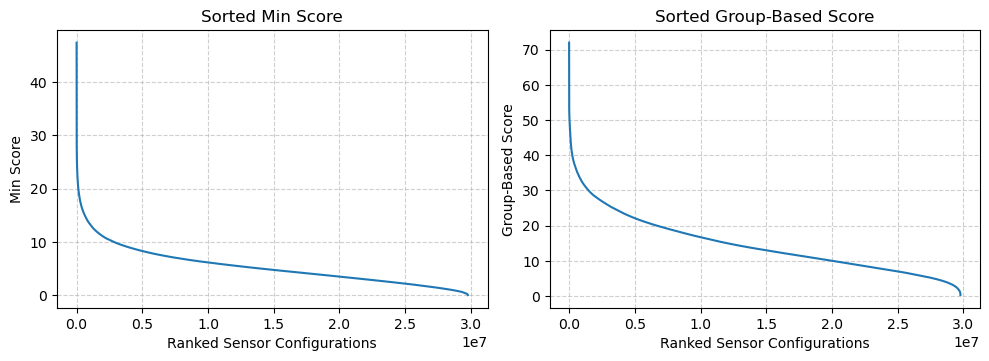

In [21]:
import matplotlib.pyplot as plt

# Define score names and their corresponding sorted DataFrames
scores = {
    "Min Score": results_sorted_min["min_score"],
    # "Mean-Min Score": results_sorted_mean_min["mean_min_score"],
    "Group-Based Score": results_sorted_group_based["group_based_score"],
    # "Weighted Mean-Min Score": results_sorted_weighted_mean_min["weighted_mean_min_score"],
}

# Create a plot for each score
plt.figure(figsize=(10, 10))

for i, (score_name, sorted_values) in enumerate(scores.items(), 1):
    plt.subplot(3, 2, i)  # Arrange in a grid (3 rows, 2 columns)
    plt.plot(sorted_values.values, linestyle="-")
    plt.xlabel("Ranked Sensor Configurations")
    plt.ylabel(score_name)
    plt.title(f"Sorted {score_name}")
    plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Define score names and their corresponding sorted values
scores = {
    "Min Score": results_sorted_min["min_score"].values,
    # "Mean-Min Score": results_sorted_mean_min["mean_min_score"].values,
    "Group-Based Score": results_sorted_group_based["group_based_score"].values,
    # "Weighted Mean-Min Score": results_sorted_weighted_mean_min["weighted_mean_min_score"].values,
}

# Dictionary to store elbow points
elbow_points = {}

# Create figure for plotting
plt.figure(figsize=(12, 8))

for i, (score_name, sorted_values) in enumerate(scores.items(), 1):
    # Compute the elbow point using the Kneedle algorithm
    x = np.arange(len(sorted_values))
    kneedle = KneeLocator(x, sorted_values, curve="convex", direction="decreasing")
    elbow_index = kneedle.elbow
    elbow_points[score_name] = elbow_index

    # Plot each score distribution
    plt.subplot(2, 2, i)  # 2 rows, 2 columns grid
    plt.plot(sorted_values, label=f"Sorted {score_name}")
    if elbow_index is not None:
        plt.axvline(elbow_index, color="red", linestyle="--", label=f"Elbow at {elbow_index}")
    plt.xlabel("Ranked Sensor Configurations")
    plt.ylabel(score_name)
    plt.title(f"Elbow Detection: {score_name}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

# Print the detected elbow points for reference
print("Estimated elbow points:")
for score_name, elbow_index in elbow_points.items():
    print(f"{score_name}: {elbow_index}")

ModuleNotFoundError: No module named 'kneed'

In [ ]:
# Dictionary to store the count of subsets with at least 99% of the best score
top_1_percent_counts = {}

# Loop through each score and count how many subsets have at least 99% of the best score
for score_name, sorted_values in scores.items():
    best_score = sorted_values[0]  # The highest score in the sorted list
    threshold = 0.85 * best_score  # 99% of the best score
    
    count_above_threshold = np.sum(sorted_values >= threshold)  # Count how many meet the threshold
    
    top_1_percent_counts[score_name] = count_above_threshold
    print(f"{score_name}: {count_above_threshold} subsets have at least 99% of the best score.")

Min Score: 80 subsets have at least 99% of the best score.
Group-Based Score: 460 subsets have at least 99% of the best score.


In [ ]:
# def visualize_basis_functions_with_substances

def visualize_basis_functions_with_substances(
    selected_basis_funcs, 
    substances_emissivity, 
    wavelengths, 
    substance_names,
    figure_size=(8, 6)
):
    """
    Plots the selected basis functions with the original substance emissivity spectra in the background.

    Parameters:
    - selected_basis_funcs (ndarray): The selected basis functions.
    - substances_emissivity (ndarray): The emissivity spectra of substances.
    - wavelengths (ndarray): The array of wavelengths.
    - substance_names (list): List of substance names for labeling.
    """
    plt.figure(figsize=figure_size)

    # Plot original substances with transparency (background)
    for i, emissivity in enumerate(substances_emissivity.T):
        plt.plot(wavelengths, emissivity, alpha=0.2)

    # Plot selected basis functions
    for i, basis_func in enumerate(selected_basis_funcs.T):
        plt.plot(wavelengths, basis_func, label=f"Basis Function {i+1}", linewidth=2)

    # Customize plot
    # plt.title("Selected Basis Functions with Original Substance Spectra", fontsize=16)
    plt.xlabel("Wavelength", fontsize=12)
    plt.ylabel("Absorptivity", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()

    # Show plot
    plt.show()

In [ ]:
# def visualize_sensor_output_unit_length

import matplotlib.pyplot as plt
import numpy as np

def visualize_sensor_output_unit_length(sensor_outputs, substances_names=None, basis_funcs_labels=None, fontsize=10, figure_size=(8, 6)):
    """
    Visualizes sensor outputs with unit length normalization for better shape comparison.

    Parameters:
    - sensor_outputs (2D array): Sensor output values (shape = (m, n)).
    - substances_names (list or array-like of str, optional): Names of substances (columns of sensor_outputs). Defaults to None.
    - basis_funcs_labels (list or array-like of str, optional): Labels for basis functions (rows of sensor_outputs). Defaults to None.
    - fontsize (int, optional): Font size for text in the plot. Defaults to 10.

    Returns:
    - None
    """
    m, n = sensor_outputs.shape  # m = number of basis functions, n = number of substances

    # Normalize each sensor output vector to unit length
    sensor_outputs_normalized = sensor_outputs / np.linalg.norm(sensor_outputs, axis=0, keepdims=True)

    # X-axis values for the basis functions
    x = np.arange(1, m + 1)

    # Create the plot
    plt.figure(figsize=figure_size)

    # Plot each substance's sensor output as a normalized curve
    for i in range(n):
        label = substances_names[i] if substances_names is not None else f"Substance {i+1}"
        plt.plot(x, sensor_outputs_normalized[:, i], marker='o', label=label)

    # Add labels, title, and legend
    plt.xlabel("Basis Function Index", fontsize=fontsize)
    plt.ylabel("Normalized Sensor Output Values", fontsize=fontsize)
    # plt.title("Normalized Sensor Outputs Comparison", fontsize=fontsize + 2, fontweight="bold")
    plt.legend(loc="best", fontsize=fontsize)

    # Optionally label x-ticks with basis function labels
    if basis_funcs_labels is not None:
        plt.xticks(ticks=x, labels=basis_funcs_labels, fontsize=fontsize)
    else:
        plt.xticks(ticks=x, fontsize=fontsize)

    # Show grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # Display the plot
    plt.tight_layout()
    plt.show()

In [ ]:
# def analyze_and_visualize_sensor_output
# --------------------------------------------------------------------------------------------------

def analyze_and_visualize_sensor_output(
    selected_subset_indices, 
    gaussian_basis_functions, 
    wavelengths, 
    substances_emissivity, 
    temperature_K, 
    atmospheric_distance_ratio, 
    air_refractive_index, 
    air_transmittance, 
    spectral_angle_mapper, 
    substance_names,
    colorbar_min=None, 
    colorbar_max=None,
    figure_size=(8, 6)
):
    """
    Analyzes and visualizes sensor output and distance matrix for a selected set of basis functions.

    Parameters:
    - selected_subset_indices (list): Indices of the selected basis functions.
    - gaussian_basis_functions (ndarray): Array of generated basis functions.
    - wavelengths (ndarray): The array of wavelengths.
    - substances_emissivity (ndarray): Emissivity spectra of substances.
    - temperature_K (float): Temperature in Kelvin.
    - atmospheric_distance_ratio (float): Atmospheric distance ratio.
    - air_refractive_index (float): Air refractive index.
    - air_transmittance (ndarray): Air transmittance values.
    - spectral_angle_mapper (callable): Function for computing SAM distance matrix.
    - substance_names (list): List of substance names for labeling.
    - colorbar_min (float, optional): Minimum value for the color scale in distance matrix visualization. Defaults to None (auto).
    - colorbar_max (float, optional): Maximum value for the color scale in distance matrix visualization. Defaults to None (auto).

    Returns:
    - sensor_outputs (ndarray): The computed sensor outputs.
    - distance_matrix (ndarray): The computed distance matrix.
    """

    # Retrieve the basis functions corresponding to the selected subset
    selected_basis_funcs = gaussian_basis_functions[:, selected_subset_indices]

    # Convert selected_subset_indices to a tuple for direct comparison
    selected_indices_tuple = tuple(sorted(selected_subset_indices))
    # Find the rank by locating the matching basis_function_indices in results_sorted_min
    rank_min = (results_sorted_min["basis_function_indices"].apply(tuple) == selected_indices_tuple).idxmax()
    rank_group = (results_sorted_group_based["basis_function_indices"].apply(tuple) == selected_indices_tuple).idxmax()
    # Print the rank (convert to 1-based indexing)
    print(f"Rank of selected_basis_funcs in results_sorted_min: {rank_min + 1}")
    print(f"Rank of selected_basis_funcs in results_sorted_group_based: {rank_group + 1}")

    # Generate the A matrix using the selected basis functions
    sensor_outputs = simulate_sensor_output(
        wavelengths=wavelengths,
        substances_emissivity=substances_emissivity,
        basis_functions=selected_basis_funcs,
        temperature_K=temperature_K,
        atmospheric_distance_ratio=atmospheric_distance_ratio,
        air_refractive_index=air_refractive_index,
        air_transmittance=air_transmittance
    )

    # Compute the distance matrix using the SAM metric
    distance_matrix = compute_distance_matrix(sensor_outputs, spectral_angle_mapper)
    min_based_score = min_based_dissimilarity_score(distance_matrix)
    group_based_score = group_based_dissimilarity_score(distance_matrix, groups)
    print(f"Min-Based Dissimilarity Score: {min_based_score}")
    print(f"Group-Based Dissimilarity Score: {group_based_score}")

    # Visualizations
    visualize_basis_functions_with_substances(selected_basis_funcs, substances_emissivity, wavelengths, substance_names, figure_size=figure_size)
    visualize_sensor_output(sensor_outputs, substance_names, figure_size=figure_size)
    visualize_sensor_output_unit_length(sensor_outputs, substance_names, figure_size=figure_size)
    visualize_distance_matrix(distance_matrix, substance_names, colorbar_min=colorbar_min, colorbar_max=colorbar_max, figure_size=figure_size)

    return sensor_outputs, distance_matrix  # Return for further analysis if needed

Rank of selected_basis_funcs in results_sorted_min: 1
Rank of selected_basis_funcs in results_sorted_group_based: 562
Min-Based Dissimilarity Score: 47.415745003512654
Group-Based Dissimilarity Score: 60.47469800907464


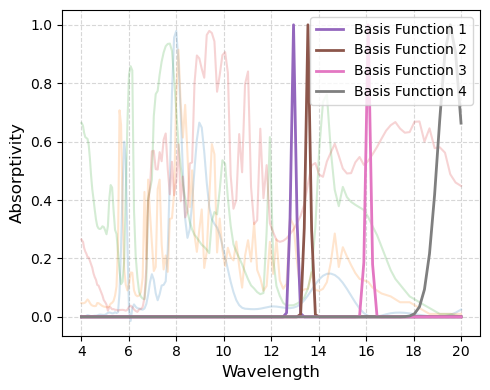

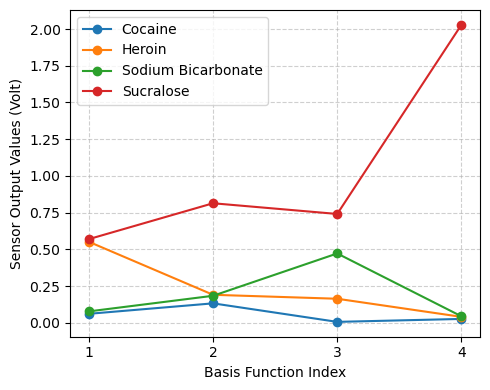

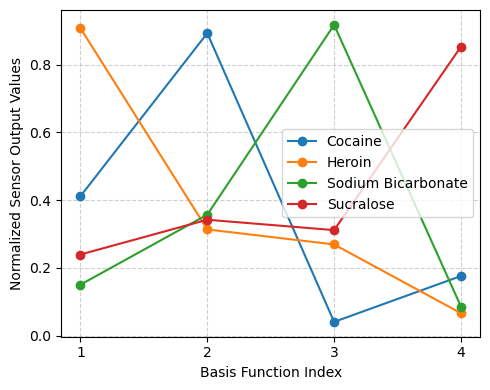

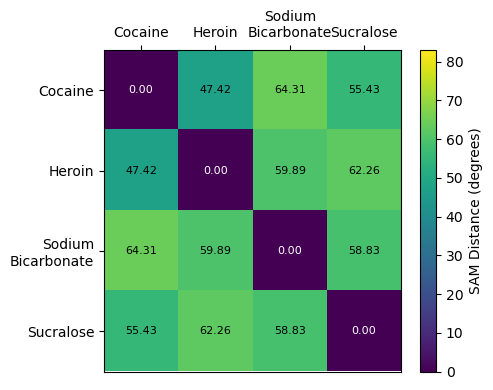

In [ ]:
# Visulizing best_result_min
selected_subset_indices = list(best_result_min["basis_function_indices"])

sensor_outputs, distance_matrix = analyze_and_visualize_sensor_output(
    selected_subset_indices,
    gaussian_basis_functions,
    wavelengths,
    emissivity_curves,
    temperature_K,
    atmospheric_distance_ratio,
    air_refractive_index,
    air_transmittance,
    spectral_angle_mapper,
    substance_names,
    colorbar_min=0,
    colorbar_max=83.01,
    figure_size=(5, 4)
)

Rank of selected_basis_funcs in results_sorted_min: 29772765
Rank of selected_basis_funcs in results_sorted_group_based: 29651265
Min-Based Dissimilarity Score: 0.007109499319879905
Group-Based Dissimilarity Score: 1.762276689054568


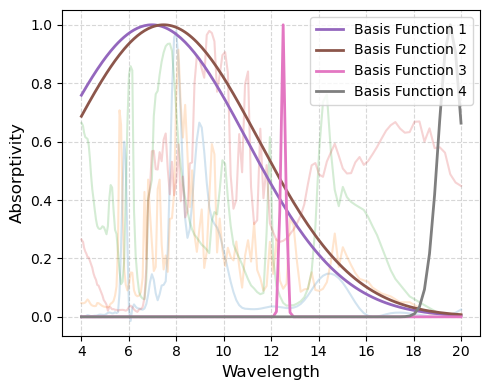

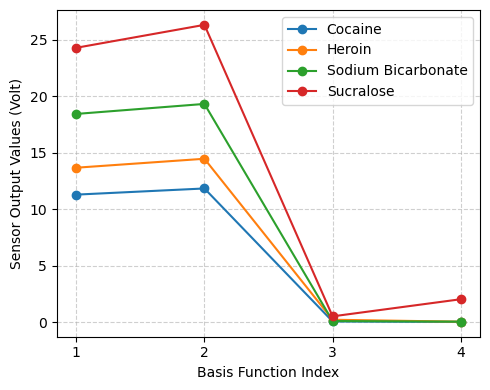

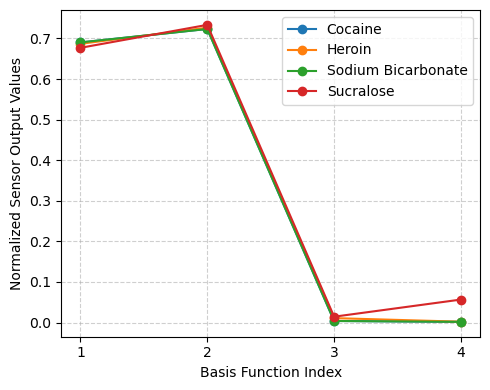

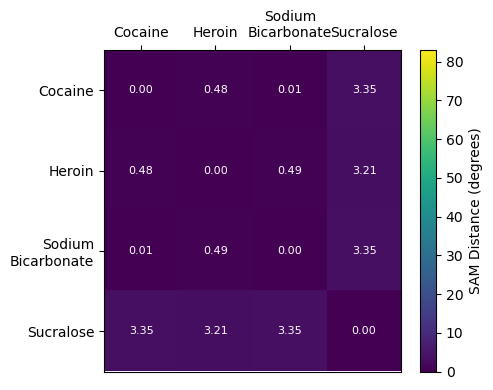

In [ ]:
# Visulizing worst_result_min
worst_result_min = results_sorted_min.iloc[-1]
selected_subset_indices = list(worst_result_min["basis_function_indices"])

sensor_outputs, distance_matrix = analyze_and_visualize_sensor_output(
    selected_subset_indices,
    gaussian_basis_functions,
    wavelengths,
    emissivity_curves,
    temperature_K,
    atmospheric_distance_ratio,
    air_refractive_index,
    air_transmittance,
    spectral_angle_mapper,
    substance_names,
    colorbar_min=0,
    colorbar_max=83.01,
    figure_size=(5, 4)
)

Rank of selected_basis_funcs in results_sorted_min: 15112516
Rank of selected_basis_funcs in results_sorted_group_based: 1
Min-Based Dissimilarity Score: 4.70544834854863
Group-Based Dissimilarity Score: 71.96578710986319


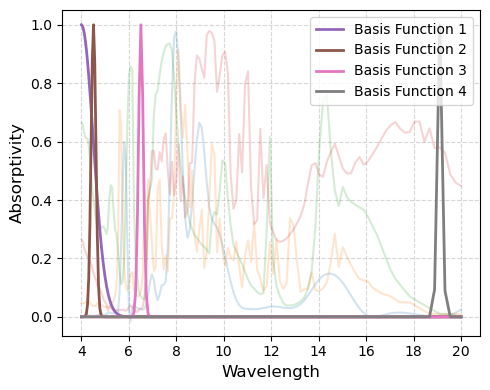

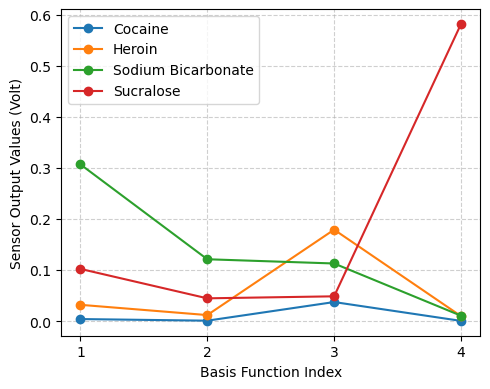

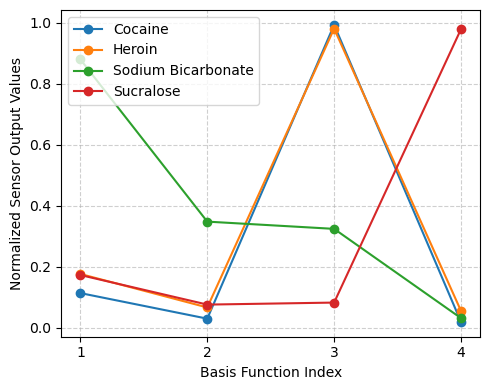

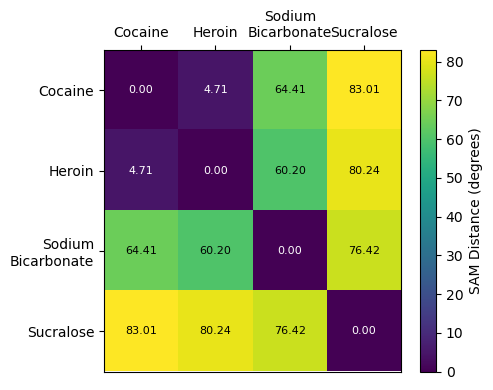

In [ ]:
# Visulizing best_result_group_based
selected_subset_indices = list(best_result_group_based["basis_function_indices"])

sensor_outputs, distance_matrix = analyze_and_visualize_sensor_output(
    selected_subset_indices,
    gaussian_basis_functions,
    wavelengths,
    emissivity_curves,
    temperature_K,
    atmospheric_distance_ratio,
    air_refractive_index,
    air_transmittance,
    spectral_angle_mapper,
    substance_names,
    figure_size=(5, 4)
)

/var/folders/_5/djzw6sx97p1_1hwr9f8lzn4r0000gn/T/ipykernel_2552/90062224.py:45: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniforge/base/envs/nn/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


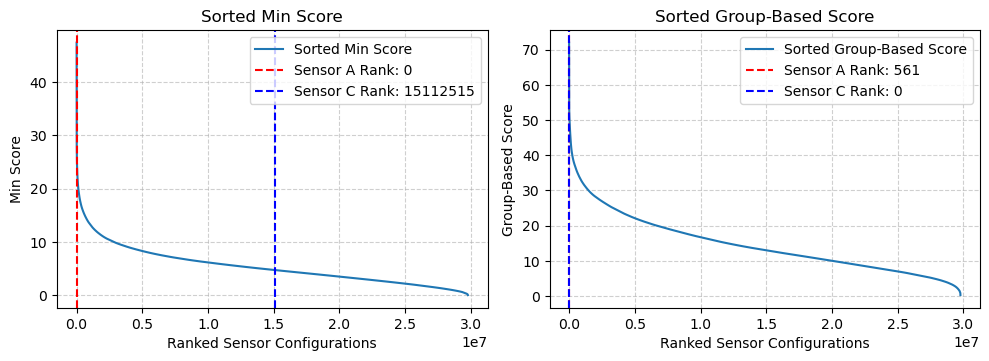

In [ ]:
import matplotlib.pyplot as plt

selected_subset_indices_A = list(best_result_min["basis_function_indices"])
selected_subset_indices_C = list(best_result_group_based["basis_function_indices"])

# Define score names and their corresponding sorted DataFrames
scores = {
    "Min Score": results_sorted_min["min_score"],
    "Group-Based Score": results_sorted_group_based["group_based_score"],
}

# Find ranks of Sensor A and Sensor C
selected_indices_A_tuple = tuple(sorted(selected_subset_indices_A))  # Convert to tuple
selected_indices_C_tuple = tuple(sorted(selected_subset_indices_C))  # Convert to tuple

# Get the rank of Sensor A and Sensor C in Min Score ranking
rank_A_min = (results_sorted_min["basis_function_indices"].apply(tuple) == selected_indices_A_tuple).idxmax()
rank_C_min = (results_sorted_min["basis_function_indices"].apply(tuple) == selected_indices_C_tuple).idxmax()

# Get the rank of Sensor A and Sensor C in Group-Based Score ranking
rank_A_group = (results_sorted_group_based["basis_function_indices"].apply(tuple) == selected_indices_A_tuple).idxmax()
rank_C_group = (results_sorted_group_based["basis_function_indices"].apply(tuple) == selected_indices_C_tuple).idxmax()

# Create a plot for each score
plt.figure(figsize=(10, 10))

for i, (score_name, sorted_values) in enumerate(scores.items(), 1):
    plt.subplot(3, 2, i)  # Arrange in a grid (3 rows, 2 columns)
    plt.plot(sorted_values.values, linestyle="-", label=f"Sorted {score_name}")

    # Add red dashed lines for Sensor A and Sensor C ranks
    if score_name == "Min Score":
        plt.axvline(rank_A_min, color="red", linestyle="--", label=f"Sensor A Rank: {rank_A_min}")
        plt.axvline(rank_C_min, color="blue", linestyle="--", label=f"Sensor C Rank: {rank_C_min}")
    elif score_name == "Group-Based Score":
        plt.axvline(rank_A_group, color="red", linestyle="--", label=f"Sensor A Rank: {rank_A_group}")
        plt.axvline(rank_C_group, color="blue", linestyle="--", label=f"Sensor C Rank: {rank_C_group}")

    plt.xlabel("Ranked Sensor Configurations")
    plt.ylabel(score_name)
    plt.title(f"Sorted {score_name}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

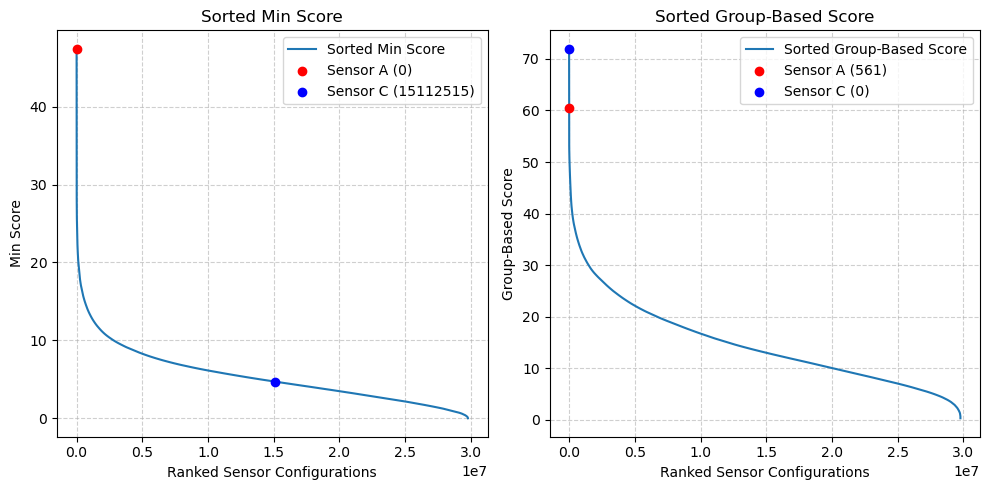

In [ ]:
import matplotlib.pyplot as plt

# Define score names and their corresponding sorted DataFrames
scores = {
    "Min Score": results_sorted_min["min_score"],
    "Group-Based Score": results_sorted_group_based["group_based_score"],
}

# Find ranks of Sensor A and Sensor C
selected_indices_A_tuple = tuple(sorted(selected_subset_indices_A))  # Convert to tuple
selected_indices_C_tuple = tuple(sorted(selected_subset_indices_C))  # Convert to tuple

# Get the rank of Sensor A and Sensor C in Min Score ranking
rank_A_min = (results_sorted_min["basis_function_indices"].apply(tuple) == selected_indices_A_tuple).idxmax()
rank_C_min = (results_sorted_min["basis_function_indices"].apply(tuple) == selected_indices_C_tuple).idxmax()

# Get the rank of Sensor A and Sensor C in Group-Based Score ranking
rank_A_group = (results_sorted_group_based["basis_function_indices"].apply(tuple) == selected_indices_A_tuple).idxmax()
rank_C_group = (results_sorted_group_based["basis_function_indices"].apply(tuple) == selected_indices_C_tuple).idxmax()

# Create a plot for each score
plt.figure(figsize=(10, 5))  # Adjust figure size for better spacing

for i, (score_name, sorted_values) in enumerate(scores.items(), 1):
    plt.subplot(1, 2, i)  # 1 row, 2 columns for side-by-side comparison
    plt.plot(sorted_values.values, linestyle="-", label=f"Sorted {score_name}")

    # Mark Sensor A and Sensor C with dots
    if score_name == "Min Score":
        plt.scatter(rank_A_min, sorted_values.iloc[rank_A_min], color="red", label=f"Sensor A ({rank_A_min})", zorder=3)
        plt.scatter(rank_C_min, sorted_values.iloc[rank_C_min], color="blue", label=f"Sensor C ({rank_C_min})", zorder=3)
    elif score_name == "Group-Based Score":
        plt.scatter(rank_A_group, sorted_values.iloc[rank_A_group], color="red", label=f"Sensor A ({rank_A_group})", zorder=3)
        plt.scatter(rank_C_group, sorted_values.iloc[rank_C_group], color="blue", label=f"Sensor C ({rank_C_group})", zorder=3)

    plt.xlabel("Ranked Sensor Configurations")
    plt.ylabel(score_name)
    plt.title(f"Sorted {score_name}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

KeyError: 'Weighted Mean-Min Score'

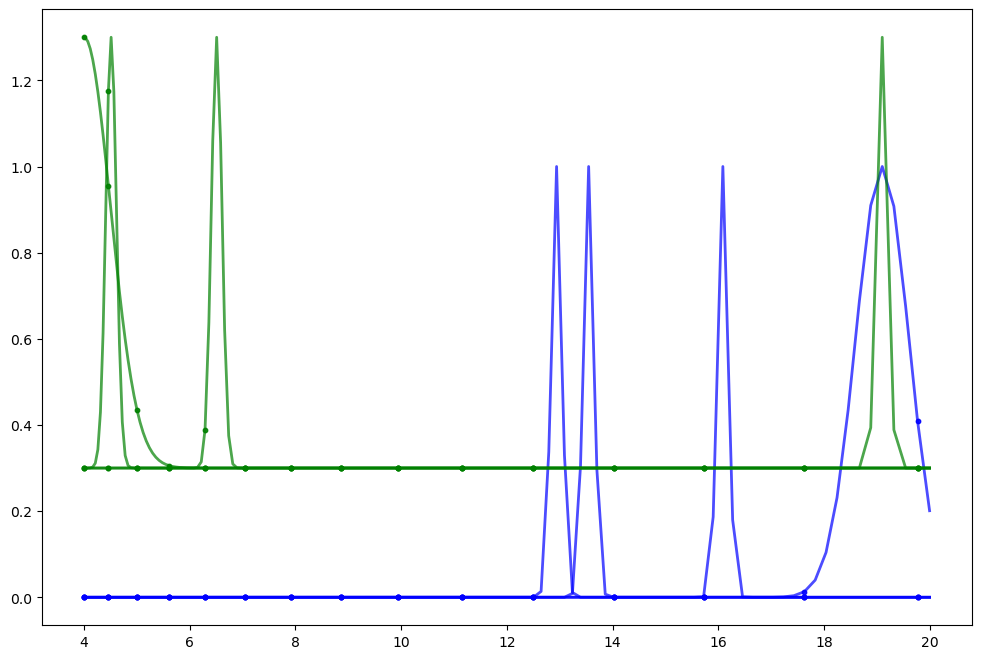

In [ ]:
# Plotting best set of basis functions chosen by differerent algorithms

import matplotlib.pyplot as plt
import numpy as np

# Colors for each score
score_colors = {
    "Mean-Min Score": "blue",
    "Group-Based Score": "green",
    "Weighted Mean-Min Score": "orange",
    "FOM Score": "red"
}

# Ensure FOM score uses ascending order for the best result
# best_result_fom = results_df.sort_values(by="fom_score", ascending=True).iloc[0]

# Retrieve the best subset of indices for each score
best_indices = {
    "Mean-Min Score": list(best_result_mean_min["basis_function_indices"]),
    "Group-Based Score": list(best_result_group_based["basis_function_indices"]),
    # "Weighted Mean-Min Score": list(best_result_weighted_mean_min["basis_function_indices"]),
    # "FOM Score": list(best_result_fom["basis_function_indices"])  # Corrected for ascending order
}

# Create a figure for the plot
plt.figure(figsize=(12, 8))

# Plot the best basis functions for each score
for score_offset, (score_name, color) in enumerate(score_colors.items()):
    indices = best_indices[score_name]  # Get indices of the best subset for this score
    basis_funcs = gaussian_basis_functions[:, indices]  # Retrieve the basis functions

    # Apply a larger vertical offset for this score
    vertical_offset = score_offset * 0.3  # Larger offset to fully separate groups

    for i, basis_func in enumerate(basis_funcs.T):  # Transpose for iteration over columns
        plt.plot(
            wavelengths,
            basis_func + vertical_offset,
            color=color,
            alpha=0.7,  # Make curves slightly transparent
            label=f"{score_name}" if i == 0 else None,
            linewidth=2
        )

        # Add markers for clarity
        plt.scatter(
            wavelengths[::10],  # Plot markers every 10 data points for readability
            basis_func[::10] + vertical_offset,
            color=color,
            alpha=0.9,
            s=10  # Marker size
        )

# Customize the plot
plt.title("Best Basis Functions by Scoring Method", fontsize=16)
plt.xlabel("Wavelength", fontsize=12)
plt.ylabel("Absorptivity", fontsize=12)
plt.legend(title="Scoring Methods", loc="upper right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

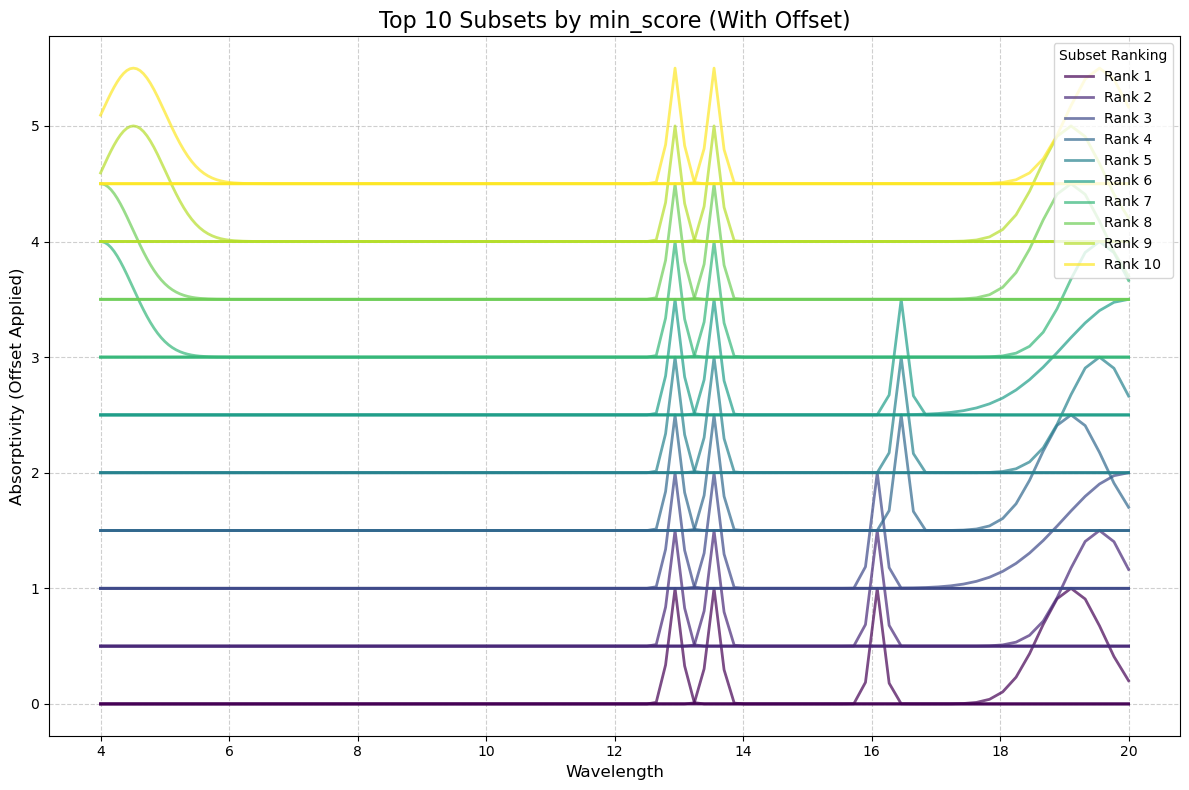

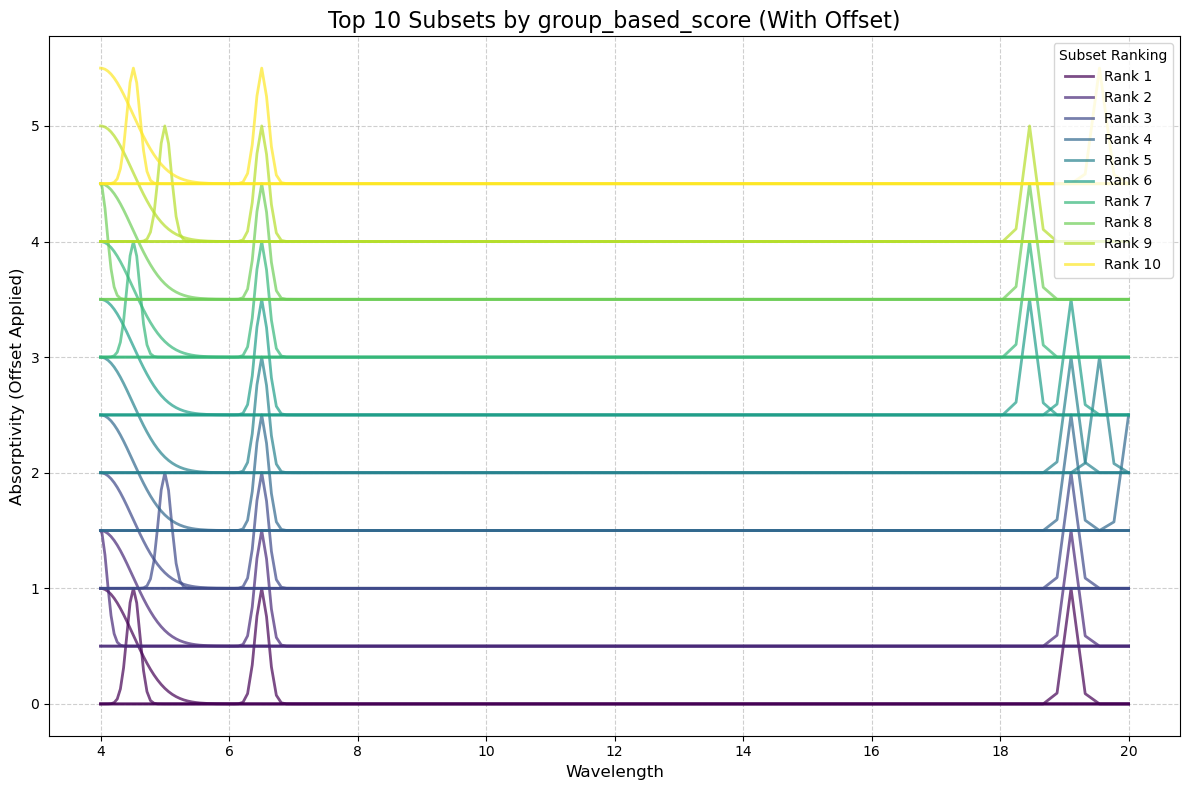

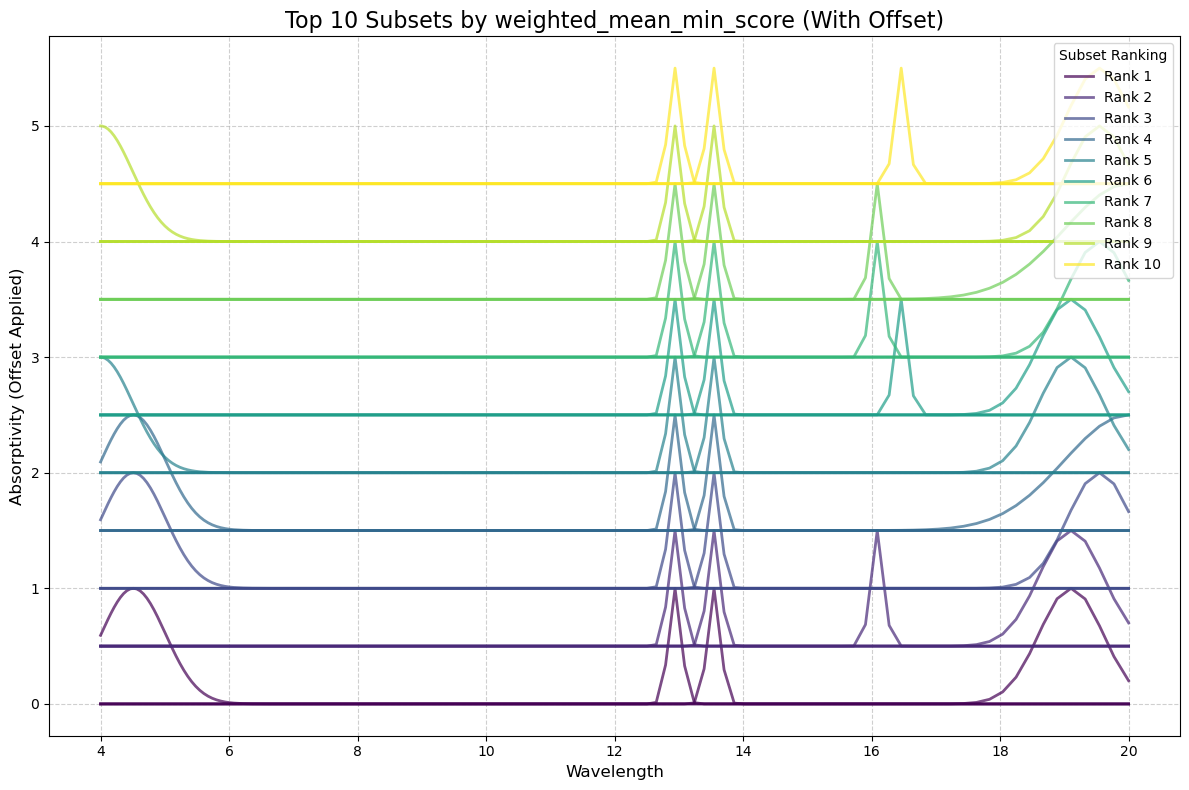

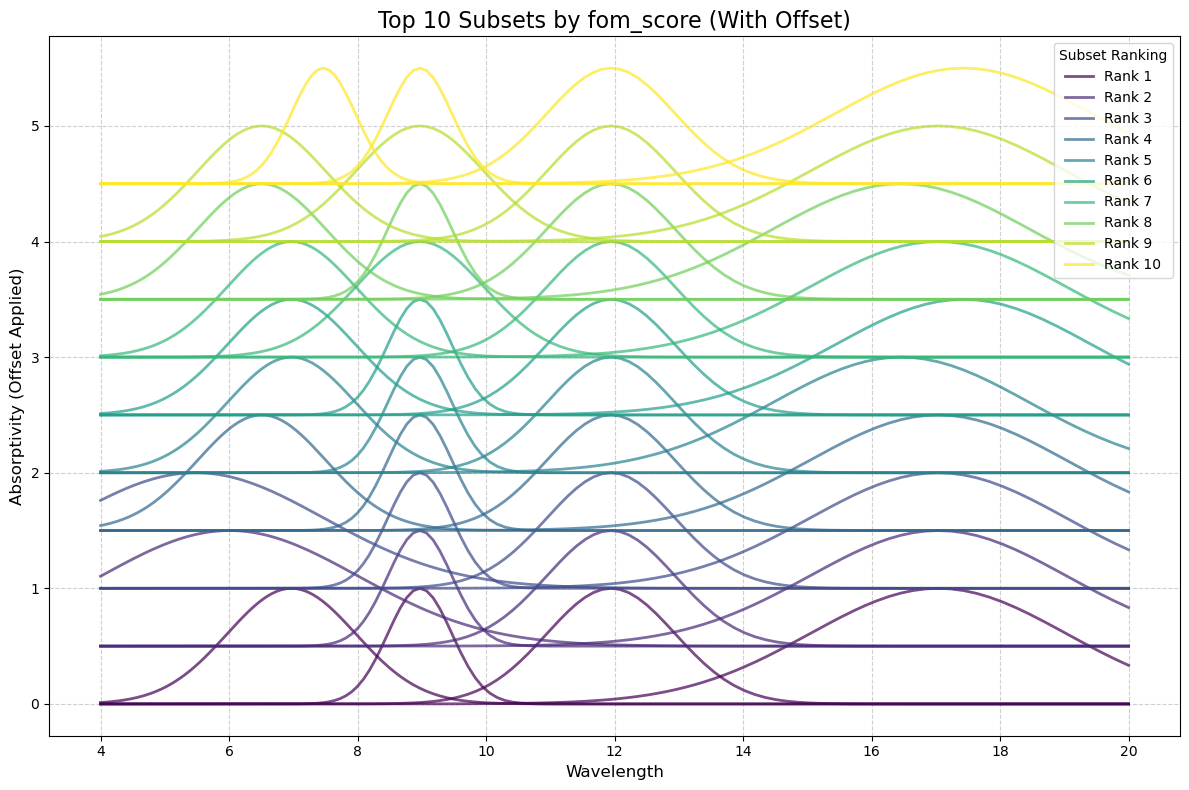

In [ ]:
# Plotting top 10 best basis functions by each algorithm with offset

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm  # For color maps

def plot_top_10_basis_functions_with_offset(score_name, sorted_results_df, gaussian_basis_functions, wavelengths, vertical_offset=0.2):
    """
    Plots the top 10 subsets of basis functions for a specific score with vertical offset.

    Parameters:
    - score_name (str): The column name of the score in the DataFrame.
    - sorted_results_df (DataFrame): The already sorted DataFrame containing the subsets and their scores.
    - gaussian_basis_functions (ndarray): Array of generated basis functions.
    - wavelengths (ndarray): The array of wavelengths.
    - vertical_offset (float): The vertical offset between subsets.
    """
    # Extract the top 10 subsets (no need to sort again)
    top_10_results = sorted_results_df.head(10)
    top_10_subsets = top_10_results["basis_function_indices"]
    
    # Generate a colormap for the top 10 subsets
    colors = cm.viridis(np.linspace(0, 1, 10))  # Use a colormap with 10 distinct colors

    # Create a figure
    plt.figure(figsize=(12, 8))
    
    for rank, (subset, color) in enumerate(zip(top_10_subsets, colors)):
        indices = list(subset)  # Extract the basis function indices for this subset
        basis_funcs = gaussian_basis_functions[:, indices]  # Retrieve the basis functions

        # Plot each basis function in the subset with vertical offset
        for i, basis_func in enumerate(basis_funcs.T):  # Transpose for iteration over columns
            plt.plot(
                wavelengths,
                basis_func + rank * vertical_offset,  # Apply vertical offset
                color=color,
                alpha=0.7,
                label=f"Rank {rank + 1}" if i == 0 else None,  # Only label once per subset
                linewidth=2
            )

    # Customize the plot
    plt.title(f"Top 10 Subsets by {score_name} (With Offset)", fontsize=16)
    plt.xlabel("Wavelength", fontsize=12)
    plt.ylabel("Absorptivity (Offset Applied)", fontsize=12)
    plt.legend(title="Subset Ranking", loc="upper right", fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Use pre-sorted DataFrames instead of re-sorting
plot_top_10_basis_functions_with_offset("min_score", results_sorted_mean_min, gaussian_basis_functions, wavelengths, vertical_offset=0.5)
plot_top_10_basis_functions_with_offset("group_based_score", results_sorted_group_based, gaussian_basis_functions, wavelengths, vertical_offset=0.5)
# plot_top_10_basis_functions_with_offset("weighted_mean_min_score", results_sorted_weighted_mean_min, gaussian_basis_functions, wavelengths, vertical_offset=0.5)
# plot_top_10_basis_functions_with_offset("fom_score", results_sorted_fom, gaussian_basis_functions, wavelengths, vertical_offset=0.5)

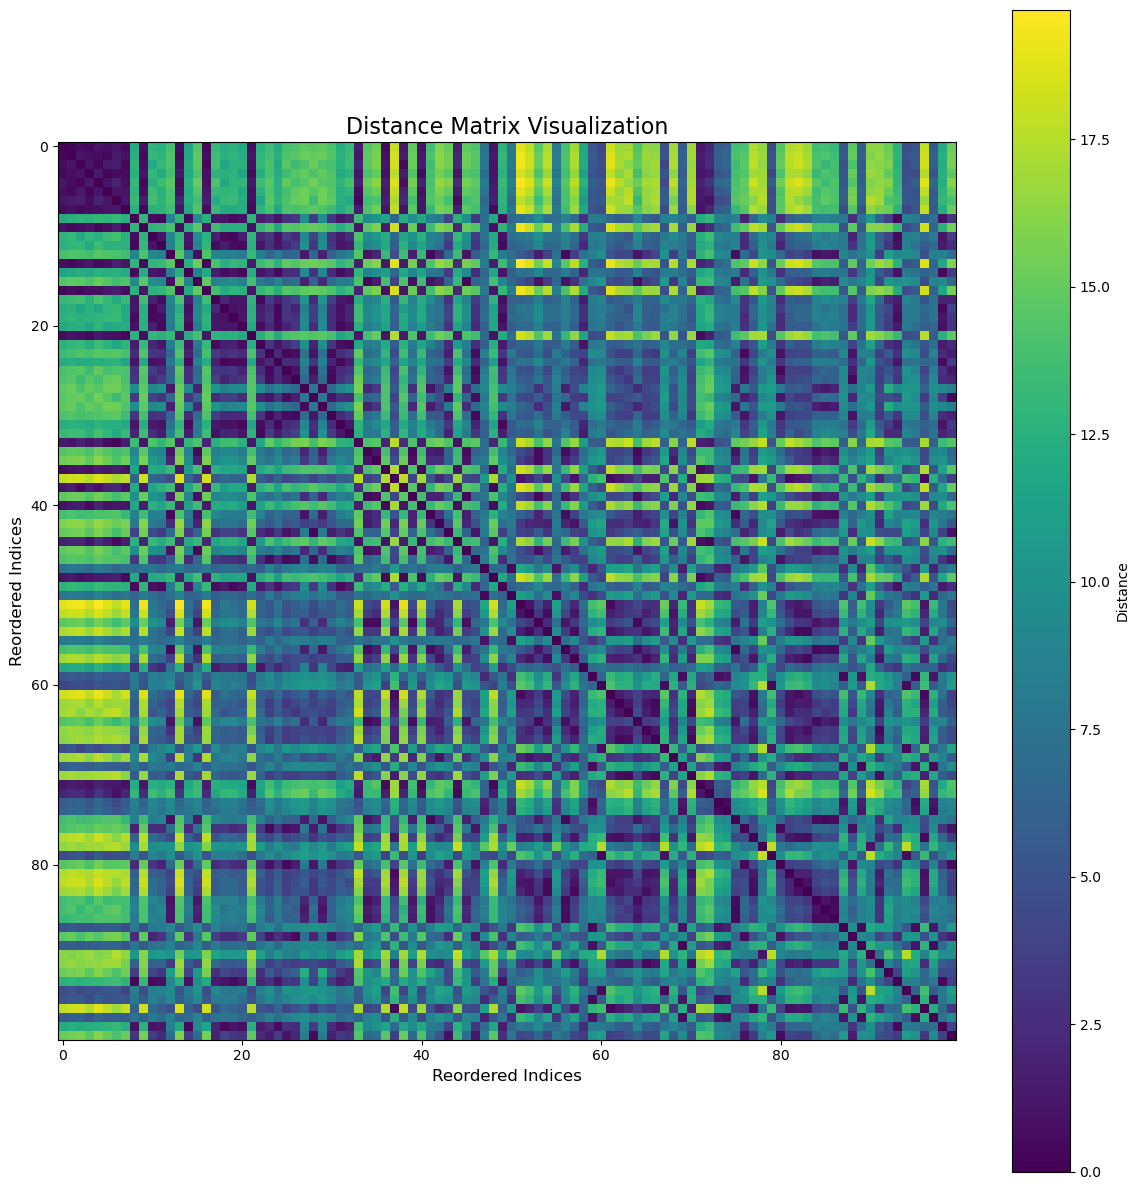

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment

# Function to compute the optimal distance between two sets
def compute_optimal_set_distance(means, sigmas, set_1_indices, set_2_indices):
    """
    Compute the distance between two sets of basis functions using optimal pairing.

    Parameters:
    - means (ndarray): Means of all basis functions.
    - sigmas (ndarray): Sigmas of all basis functions.
    - set_1_indices (list): Indices of basis functions in set 1.
    - set_2_indices (list): Indices of basis functions in set 2.

    Returns:
    - optimal_distance (float): Total optimal distance between the two sets.
    """
    set_1 = np.array([[means[i], sigmas[i]] for i in set_1_indices])
    set_2 = np.array([[means[j], sigmas[j]] for j in set_2_indices])
    pairwise_distances = np.zeros((len(set_1), len(set_2)))
    for i, b1 in enumerate(set_1):
        for j, b2 in enumerate(set_2):
            pairwise_distances[i, j] = np.sqrt((b1[0] - b2[0])**2 + (b1[1] - b2[1])**2)
    row_indices, col_indices = linear_sum_assignment(pairwise_distances)
    return pairwise_distances[row_indices, col_indices].sum()

# Assuming `results_df` is already processed and sorted
# Example: Top 10 subsets based on "min_score"
top_10_results = results_sorted_min.iloc[0:100]  # First 10 rows of the DataFrame
top_10_subsets = top_10_results["basis_function_indices"].tolist()  # Extract subsets (list of lists)

# Initialize the distance matrix
num_subsets = len(top_10_subsets)
distance_matrix = np.zeros((num_subsets, num_subsets))

# Compute pairwise distances between all subsets
for i in range(num_subsets):
    for j in range(i, num_subsets):  # Only compute upper triangular (matrix is symmetric)
        if i == j:
            distance_matrix[i, j] = 0  # Distance to itself is 0
        else:
            distance_matrix[i, j] = compute_optimal_set_distance(
                all_means, all_sigmas, top_10_subsets[i], top_10_subsets[j]
            )
            distance_matrix[j, i] = distance_matrix[i, j]  # Symmetric matrix

# print("Distance Matrix:")
# print(distance_matrix)

# Perform iVAT (if an iVAT implementation is available)
# Replace this with your iVAT visualization function
# Example: from pyclustertend import ivat
# ivat(distance_matrix)
def visualize_distance_matrix_large(distance_matrix, title="Distance Matrix Visualization"):
    """
    Visualizes a distance matrix as a heatmap.

    Parameters:
    - distance_matrix (2D ndarray): Pairwise distance matrix.
    - title (str): Title for the plot.
    """
    plt.figure(figsize=(12, 12))
    plt.imshow(distance_matrix, cmap='viridis', origin='upper')
    plt.colorbar(label="Distance")
    plt.title(title, fontsize=16)
    plt.xlabel("Reordered Indices", fontsize=12)
    plt.ylabel("Reordered Indices", fontsize=12)
    plt.tight_layout()
    plt.show()
    
visualize_distance_matrix_large(distance_matrix)

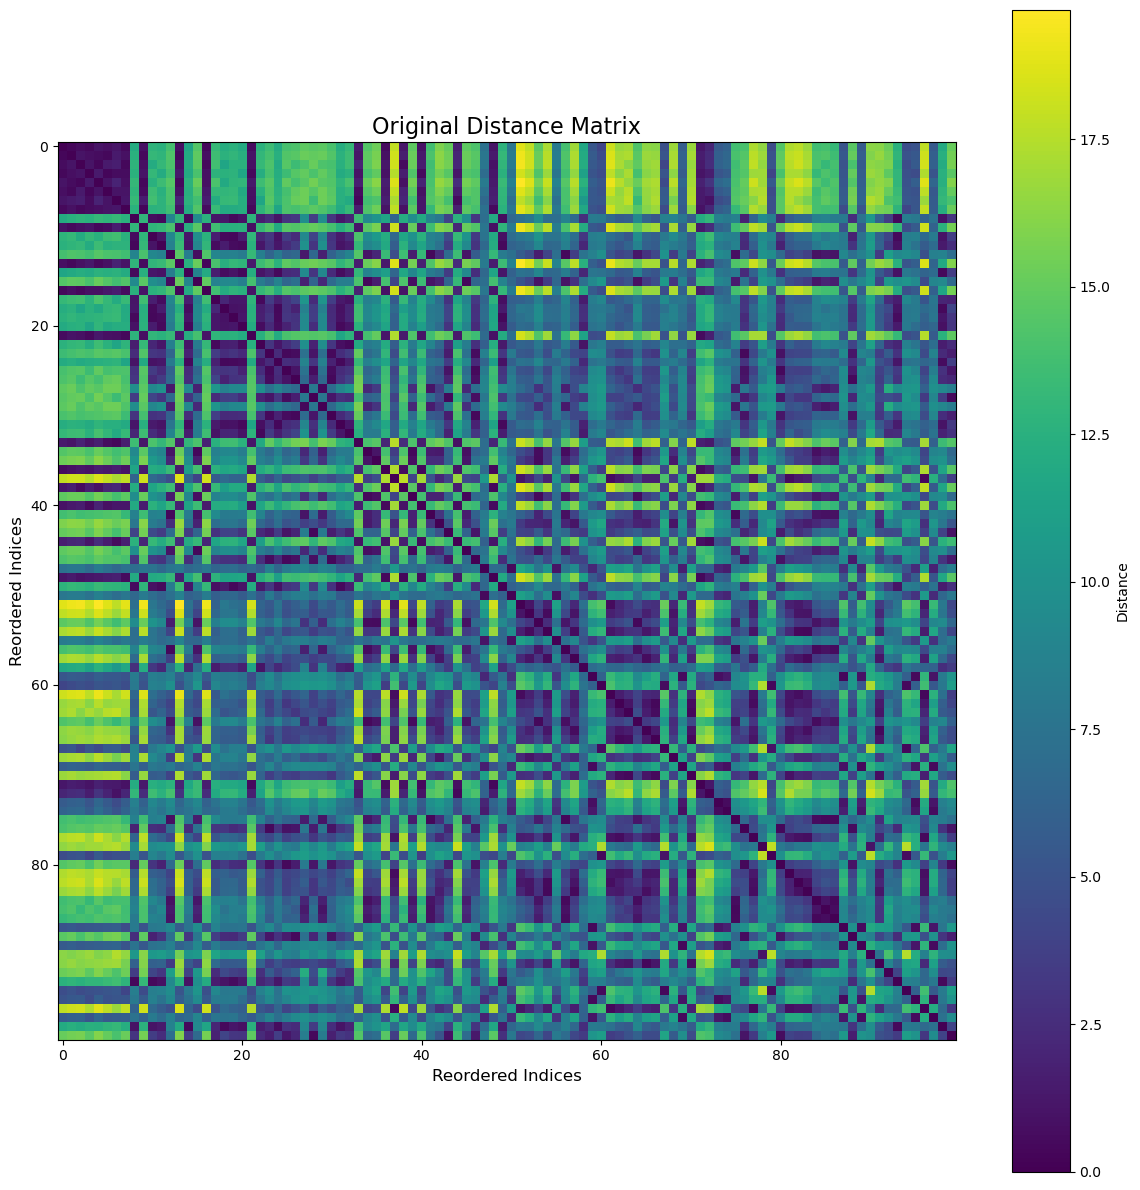

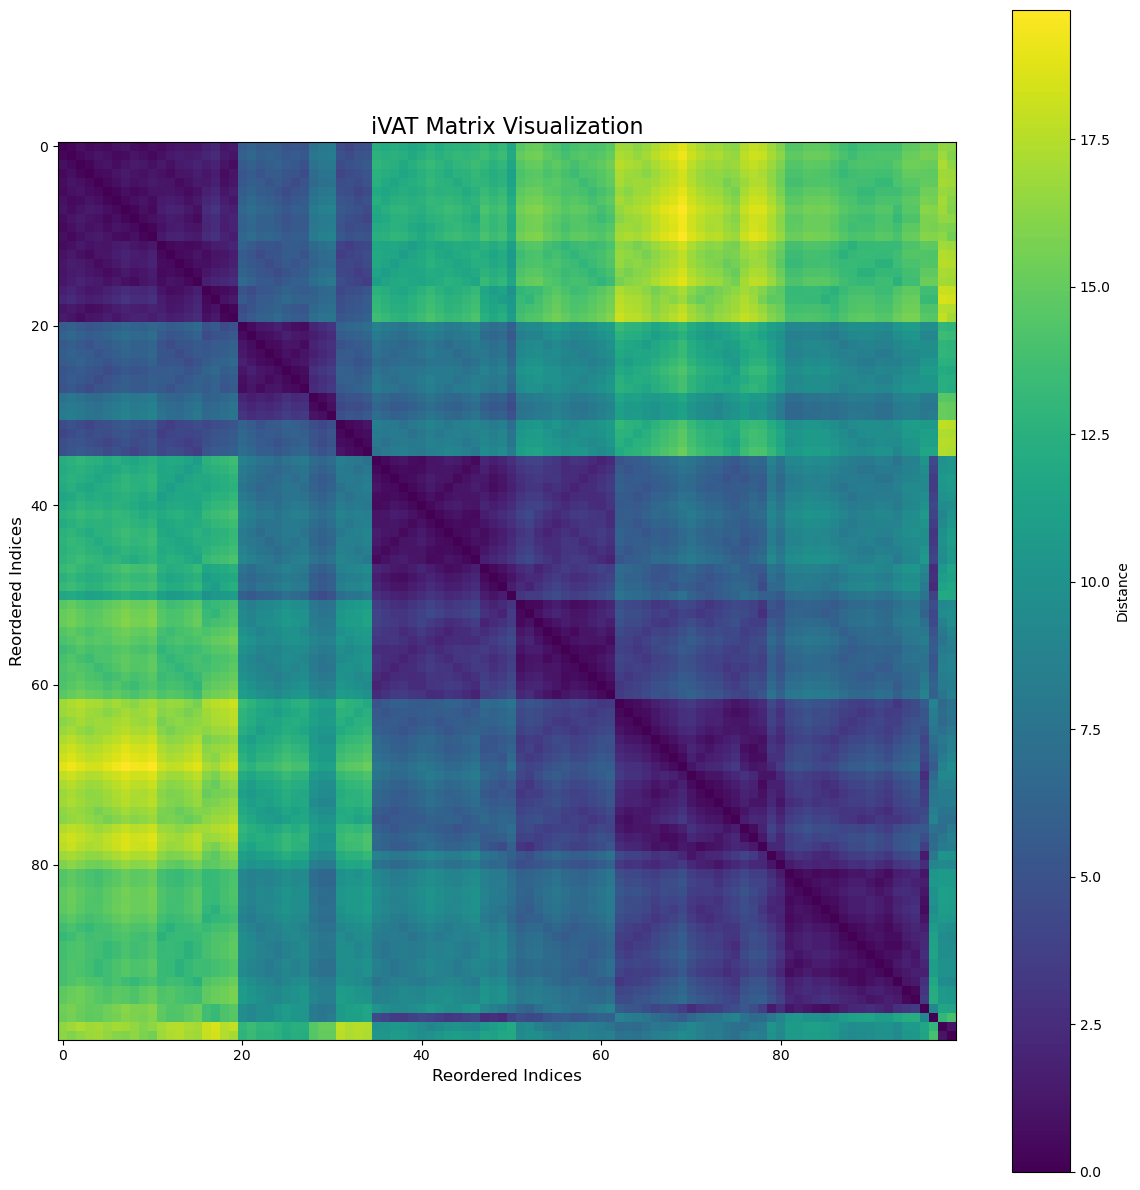

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import minimum_spanning_tree

def compute_ivat_from_distance_matrix(distance_matrix):
    """
    Computes the iVAT matrix from a given distance matrix.

    Parameters:
    - distance_matrix (2D ndarray): Pairwise distance matrix.

    Returns:
    - ivat_matrix (2D ndarray): Reordered distance matrix for iVAT visualization.
    - reorder (list): The reordering of indices for the iVAT matrix.
    """
    n = distance_matrix.shape[0]

    # Initialize reordering
    reorder = [0]  # Start with the first index
    remaining = set(range(1, n))

    # Build the iVAT ordering based on nearest neighbors
    while remaining:
        last = reorder[-1]
        next_index = min(remaining, key=lambda x: distance_matrix[last, x])
        reorder.append(next_index)
        remaining.remove(next_index)

    # Reorder the distance matrix
    ivat_matrix = distance_matrix[np.ix_(reorder, reorder)]
    return ivat_matrix, reorder


# Compute the iVAT matrix
ivat_matrix, reorder = compute_ivat_from_distance_matrix(distance_matrix)

# Visualize the original and iVAT matrices
visualize_distance_matrix_large(distance_matrix, title="Original Distance Matrix")
visualize_distance_matrix_large(ivat_matrix, title="iVAT Matrix Visualization")

In [ ]:
print(reorder)
print(results_sorted_min["basis_function_indices"].iloc[0])

[0, 1, 5, 3, 21, 7, 9, 4, 2, 16, 13, 36, 40, 71, 48, 38, 44, 72, 6, 33, 73, 74, 97, 69, 89, 87, 59, 95, 47, 50, 55, 79, 60, 94, 67, 18, 24, 31, 20, 14, 98, 93, 8, 11, 49, 19, 10, 17, 22, 32, 58, 28, 43, 99, 80, 76, 23, 25, 46, 30, 26, 88, 63, 70, 66, 62, 77, 96, 61, 51, 52, 54, 83, 57, 65, 91, 81, 37, 82, 68, 42, 34, 15, 45, 39, 53, 64, 84, 86, 75, 41, 12, 56, 85, 29, 27, 35, 92, 78, 90]
(90, 95, 120, 156)


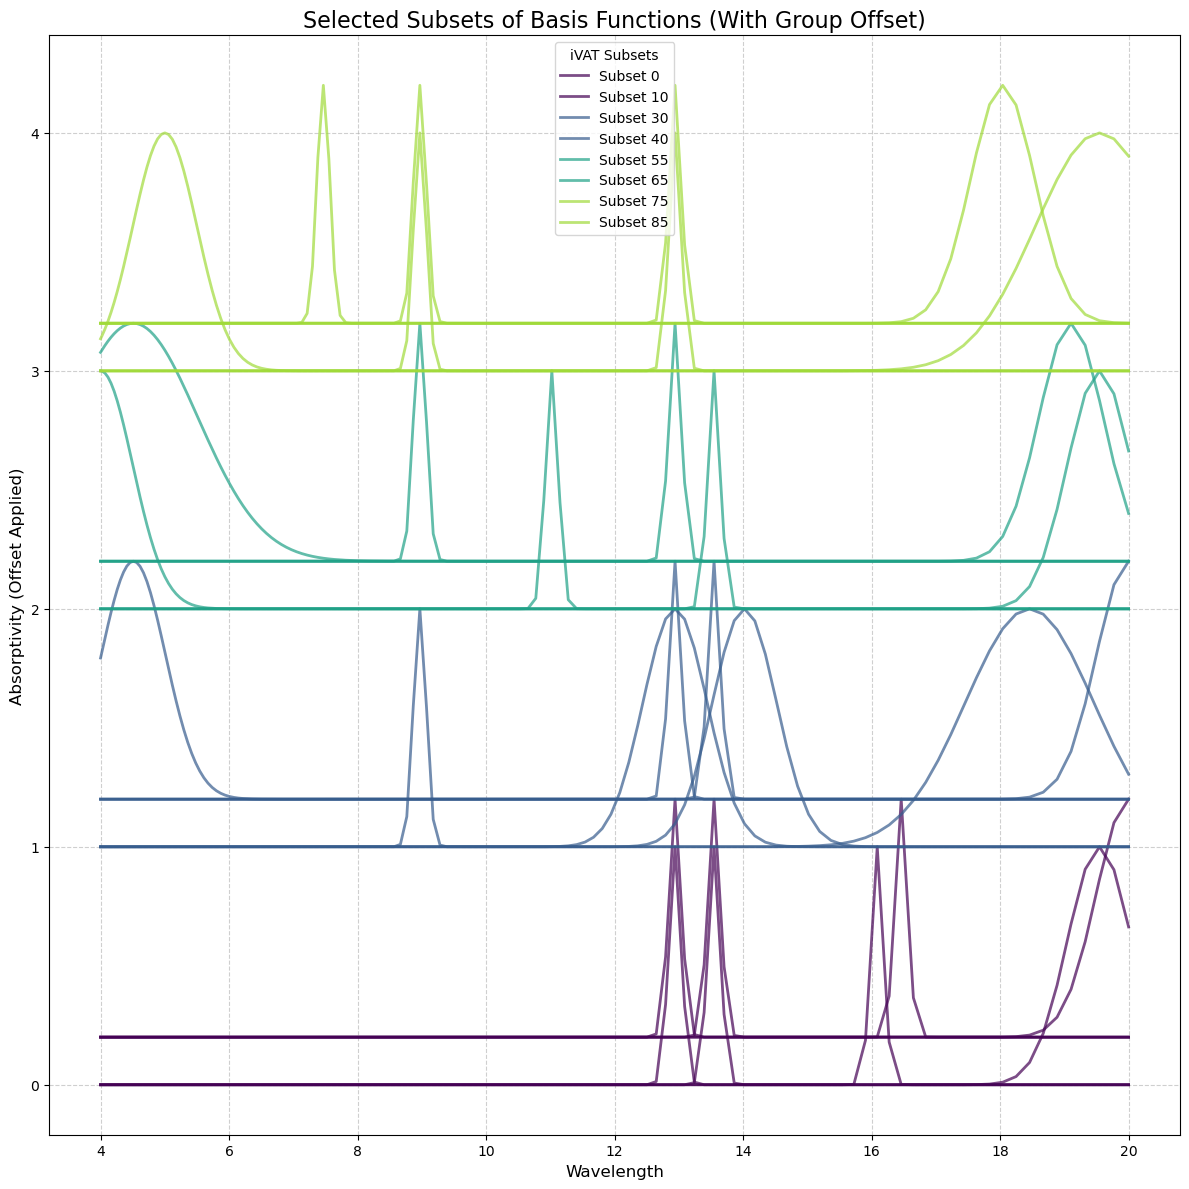

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm  # For color maps

def plot_selected_basis_functions_with_group_offset(ivat_indices, reorder, sorted_results_df, gaussian_basis_functions, wavelengths, vertical_offset=0.2, group_offset=1.0):
    """
    Plots the subsets of basis functions corresponding to specific iVAT indices with vertical offset, including double offset between groups.

    Parameters:
    - ivat_indices (list of int): The indices in the iVAT matrix to plot, grouped in pairs.
    - reorder (list): The reordering of indices from iVAT.
    - sorted_results_df (DataFrame): DataFrame containing subsets of basis functions.
    - gaussian_basis_functions (ndarray): Array of generated basis functions.
    - wavelengths (ndarray): The array of wavelengths.
    - vertical_offset (float): The vertical offset within pairs.
    - group_offset (float): The additional vertical offset between groups.
    """
    # Generate a colormap for the subsets
    colors = cm.viridis(np.linspace(0, 1, len(ivat_indices)))  # Distinct colors for each subset

    # Create a figure
    plt.figure(figsize=(12, 12))

    for group_idx, (ivat_index_pair, color) in enumerate(zip(zip(ivat_indices[::2], ivat_indices[1::2]), colors[::2])):
        group_base_offset = group_idx * group_offset  # Offset for the group

        for pair_rank, ivat_index in enumerate(ivat_index_pair):
            # Step 1: Map iVAT index to original distance matrix index
            subset_index = reorder[ivat_index]

            # Step 2: Get the subset of basis function indices from the DataFrame
            subset = sorted_results_df["basis_function_indices"].iloc[subset_index]  # This should be 4 numbers

            # Step 3: Extract and plot the basis functions from gaussian_basis_functions
            for i, basis_func_idx in enumerate(subset):
                basis_func = gaussian_basis_functions[:, basis_func_idx]  # Get the basis function
                plt.plot(
                    wavelengths,
                    basis_func + group_base_offset + pair_rank * vertical_offset,  # Apply group and pair offsets
                    color=color,
                    alpha=0.7,
                    label=f"Subset {ivat_index}" if i == 0 else None,  # Label with actual iVAT index
                    linewidth=2
                )

    # Customize the plot
    plt.title("Selected Subsets of Basis Functions (With Group Offset)", fontsize=16)
    plt.xlabel("Wavelength", fontsize=12)
    plt.ylabel("Absorptivity (Offset Applied)", fontsize=12)
    plt.legend(title="iVAT Subsets", fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
ivat_indices = [0, 10, 30, 40, 55, 65, 75, 85]  # The indices in the iVAT matrix to plot, grouped in pairs
# reorder = [...]  # The reorder list from compute_ivat_from_distance_matrix
# sorted_results_df = [...]  # DataFrame with subsets and scores
# gaussian_basis_functions = np.random.rand(100, 40)  # Example basis functions (100 wavelengths, 40 functions)
# wavelengths = np.linspace(400, 700, 100)  # Example wavelengths from 400 to 700 nm

plot_selected_basis_functions_with_group_offset(ivat_indices, reorder, results_sorted_min, gaussian_basis_functions, wavelengths, vertical_offset=0.2, group_offset=1.0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import differential_evolution

def compute_contrast(ivat_matrix, partitions):
    """
    Computes contrast as the difference between intra-cluster and inter-cluster distances.
    
    Parameters:
    - ivat_matrix (2D array): Ordered dissimilarity matrix (iVAT output).
    - partitions (list): List of cluster boundary indices.

    Returns:
    - contrast (float): Measure of intra-cluster cohesion vs inter-cluster separation.
    """
    intra_cluster_dists = []
    inter_cluster_dists = []
    
    for i in range(len(partitions) - 1):
        cluster = ivat_matrix[partitions[i]:partitions[i+1], partitions[i]:partitions[i+1]]
        intra_cluster_dists.append(np.mean(cluster))

        if i < len(partitions) - 2:
            boundary_region = ivat_matrix[partitions[i+1]-1, partitions[i+1]:partitions[i+2]]
            inter_cluster_dists.append(np.mean(boundary_region))
    
    return np.mean(inter_cluster_dists) - np.mean(intra_cluster_dists)

def compute_edginess(ivat_matrix):
    """
    Computes edginess by detecting sharp transitions in the reordered dissimilarity matrix.
    
    Parameters:
    - ivat_matrix (2D array): Ordered dissimilarity matrix (iVAT output).

    Returns:
    - peaks (array): Indices of sharp edges in the dissimilarity structure.
    """
    diagonal_values = np.diag(ivat_matrix)
    peaks, _ = find_peaks(diagonal_values, distance=5)  # Detect cluster transitions
    return peaks

def clodd_clustering(ivat_matrix, max_clusters=10):
    """
    CLODD clustering based on contrast and edginess.
    
    Parameters:
    - ivat_matrix (2D array): Ordered dissimilarity matrix (iVAT output).
    - max_clusters (int): Maximum number of clusters to search.

    Returns:
    - best_partitions (list): Optimal cluster boundary indices.
    - cluster_labels (array): Labels assigned to each data point.
    """
    n = ivat_matrix.shape[0]
    
    # Step 1: Compute potential cluster boundaries using edginess
    peaks = compute_edginess(ivat_matrix)
    
    if len(peaks) < 2:  # If no clear peaks, assume one cluster
        return [0, n], np.zeros(n, dtype=int)

    # Step 2: Define optimization function for finding best partition
    def objective_function(boundaries):
        boundaries = np.sort(np.append([0, n], boundaries.astype(int)))
        return -compute_contrast(ivat_matrix, boundaries)  # Minimize negative contrast

    # Step 3: Optimize cluster boundaries using Differential Evolution (PSO alternative)
    bounds = [(1, n-1) for _ in range(min(len(peaks), max_clusters-1))]  # Search space
    result = differential_evolution(objective_function, bounds, strategy='best1bin', maxiter=50)
    
    # Step 4: Get best partitioning
    best_partitions = np.sort(np.append([0, n], result.x.astype(int)))
    
    # Step 5: Assign cluster labels
    cluster_labels = np.zeros(n, dtype=int)
    for i in range(len(best_partitions)-1):
        cluster_labels[best_partitions[i]:best_partitions[i+1]] = i
    
    return best_partitions, cluster_labels

# Example usage with iVAT matrix (assume ivat_distance_matrix is already computed)
best_partitions, cluster_labels = clodd_clustering(ivat_distance_matrix)

# Ensure labels are formatted correctly for visualization
labels_str = [str(label) for label in cluster_labels]

# Visualization of clustered iVAT matrix
visualize_matrix(
    ivat_distance_matrix, 
    labels=labels_str, 
    title="CLODD Clustered Distance Matrix"
)

# Scatter plot of clustered data
visualize_2d_vectors(
    data_matrix, 
    labels=cluster_labels,  # Cluster labels will determine colors in scatter plot
    title="CLODD Clustering Results"
)

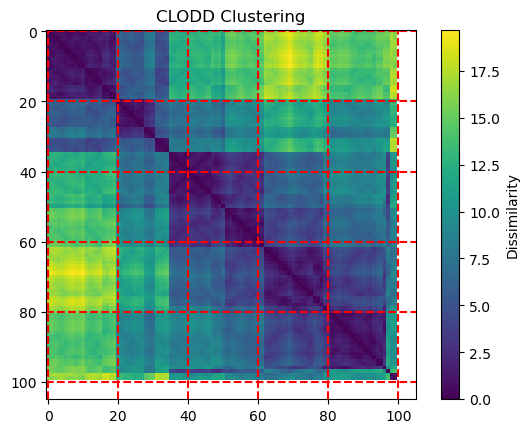

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
4.0
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
6.00678
[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
7.99871
[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
9.94369
[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
11.94399


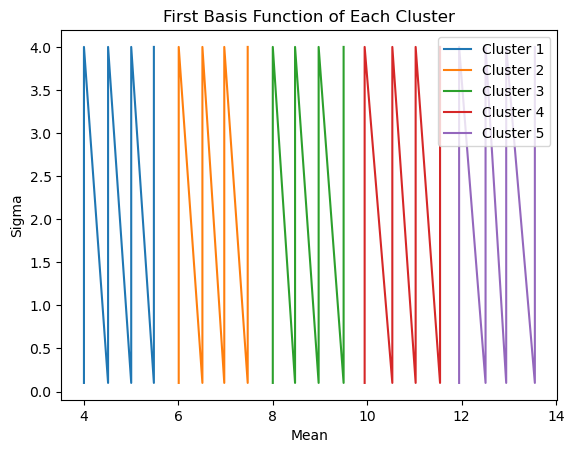

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Step 1: Define the squareness and edginess objective functions
def squareness(matrix, partition):
    """
    Computes the squareness measure for a given partition.
    Parameters:
    - matrix: Dissimilarity matrix
    - partition: List of indices indicating partition boundaries
    Returns:
    - Squareness score
    """
    score = 0
    n = len(matrix)
    for i in range(len(partition) - 1):
        block = matrix[partition[i]:partition[i+1], partition[i]:partition[i+1]]
        out_block = np.concatenate((matrix[:partition[i], partition[i]:partition[i+1]],
                                    matrix[partition[i+1]:, partition[i]:partition[i+1]]), axis=0)
        score += np.mean(out_block) - np.mean(block)
    return score

def edginess(matrix, partition):
    """
    Computes the edginess measure for a given partition.
    Parameters:
    - matrix: Dissimilarity matrix
    - partition: List of indices indicating partition boundaries
    Returns:
    - Edginess score
    """
    score = 0
    for i in range(len(partition) - 1):
        boundary = matrix[partition[i]:partition[i+1], partition[i+1]:]
        score += np.sum(np.abs(np.diff(boundary, axis=1)))
    return score

# Step 2: Define the composite objective function
def clodd_objective(partition, matrix, alpha=0.5):
    """
    Composite objective function for CLODD.
    Parameters:
    - partition: List of partition indices
    - matrix: Dissimilarity matrix
    - alpha: Weighting for squareness vs. edginess
    Returns:
    - Composite objective function value
    """
    partition = [int(p) for p in np.sort(partition)]
    return -alpha * squareness(matrix, partition) - (1 - alpha) * edginess(matrix, partition)

# Step 3: Apply Particle Swarm Optimization or a heuristic optimization approach
def optimize_clodd(matrix, num_clusters):
    """
    Optimizes the partition boundaries using CLODD objective function.
    Parameters:
    - matrix: Dissimilarity matrix
    - num_clusters: Desired number of clusters
    Returns:
    - Optimized partition indices
    """
    n = len(matrix)
    initial_guess = np.linspace(0, n, num_clusters + 1)[1:-1]  # Equal partitions as start
    result = minimize(
        clodd_objective, 
        
        x0=initial_guess, 
        args=(matrix,), 
        bounds=[(1, n-1)] * (num_clusters - 1), 
        method='L-BFGS-B'
    )
    return np.sort([0] + list(result.x) + [n]).astype(int)

# Step 4: Visualize partitions and clusters
def plot_clusters(matrix, partition, title="Clusters"):
    """
    Visualize the clusters on the iVAT reordered matrix.
    Parameters:
    - matrix: Dissimilarity matrix
    - partition: List of partition indices
    """
    plt.imshow(matrix, cmap="viridis", origin="upper")
    for p in partition:
        plt.axvline(x=p, color="red", linestyle="--")
        plt.axhline(y=p, color="red", linestyle="--")
    plt.title(title)
    plt.colorbar(label="Dissimilarity")
    plt.show()

# Step 5: Compare first basis function of each cluster
def compare_basis_functions(means, sigmas, clusters):
    """
    Compare and plot the first basis function of each identified cluster.
    Parameters:
    - means: Means of all basis functions
    - sigmas: Sigmas of all basis functions
    - clusters: List of indices for each cluster
    """
    for cluster_idx, indices in enumerate(clusters):
        print(indices)
        print(means[indices[0]])
        cluster_means = [means[i] for i in indices]
        cluster_sigmas = [sigmas[i] for i in indices]
        plt.plot(cluster_means, cluster_sigmas, label=f"Cluster {cluster_idx + 1}")
    plt.xlabel("Mean")
    plt.ylabel("Sigma")
    plt.legend()
    plt.title("First Basis Function of Each Cluster")
    plt.show()

# Example usage
# distance_matrix = ...  # Replace with your iVAT processed distance matrix
num_clusters = 5  # Replace with the number of clusters identified by CLODD

# Optimize partitions
optimal_partition = optimize_clodd(ivat_matrix, num_clusters)
plot_clusters(ivat_matrix, optimal_partition, title="CLODD Clustering")

# Extract and compare clusters (replace means and sigmas with actual data)
# all_means = ...  # Replace with means of all basis functions
# all_sigmas = ...  # Replace with sigmas of all basis functions
clusters = [list(range(optimal_partition[i], optimal_partition[i+1])) for i in range(len(optimal_partition) - 1)]
compare_basis_functions(all_means, all_sigmas, clusters)

In [ ]:
# --------------------------------------------------------------------------------------------------
# Sort and Sample Results
# --------------------------------------------------------------------------------------------------

# Sort the results separately by mean-min score and group-based score
results_df_sorted_mean_min = results_df.sort_values(by="mean_min_score", ascending=False)
results_df_sorted_group_based = results_df.sort_values(by="group_based_score", ascending=False)

# Dynamically sample 20 rows from each sorted DataFrame
num_samples = 20
indices_mean_min = np.linspace(0, len(results_df_sorted_mean_min) - 1, num_samples, dtype=int)
indices_group_based = np.linspace(0, len(results_df_sorted_group_based) - 1, num_samples, dtype=int)

# Extract the sampled DataFrames
results_sampled_mean_min = results_df_sorted_mean_min.iloc[indices_mean_min]
results_sampled_group_based = results_df_sorted_group_based.iloc[indices_group_based]

# --------------------------------------------------------------------------------------------------
# Visualization: Side-by-Side Bar Plot with Two Y-Axes
# --------------------------------------------------------------------------------------------------

# Extract scores for plotting
mean_min_scores = results_sampled_mean_min["mean_min_score"]
group_based_scores = results_sampled_group_based["group_based_score"]

# Generate labels for the subsets
mean_min_labels = results_sampled_mean_min["subset"].apply(lambda x: ", ".join(map(str, x))).tolist()
group_based_labels = results_sampled_group_based["subset"].apply(lambda x: ", ".join(map(str, x))).tolist()

# Create positions for the bars
x = np.arange(num_samples)  # Positions for the bars
bar_width = 0.4  # Width of each bar

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot mean-min scores on the left y-axis
bars_mean_min = ax1.bar(
    x - bar_width / 2,
    mean_min_scores,
    width=bar_width,
    label="Mean-Min Score",
    color="skyblue",
    edgecolor="black"
)
ax1.set_ylabel("Mean-Min Score", fontsize=12, color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.set_xlabel("Subset Index", fontsize=12)

# Create a secondary y-axis for group-based scores
ax2 = ax1.twinx()
bars_group_based = ax2.bar(
    x + bar_width / 2,
    group_based_scores,
    width=bar_width,
    label="Group-Based Score",
    color="orange",
    edgecolor="black"
)
ax2.set_ylabel("Group-Based Score", fontsize=12, color="orange")
ax2.tick_params(axis='y', labelcolor="orange")

# Add labels to each bar (beneath the x-ticks)
ax1.set_xticks(x)
ax1.set_xticklabels(
    [f"MM: {m}\nGB: {g}" for m, g in zip(mean_min_labels, group_based_labels)],
    rotation=90,
    fontsize=12,
    ha="center"
)

# Add a title and grid
plt.title("Comparison of Top Subsets by Mean-Min and Group-Based Scores", fontsize=14, fontweight="bold")

# Add legends
fig.legend(loc="upper right", fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()

KeyError: 'subset'

In [ ]:
# import matplotlib.pyplot as plt

# # --------------------------------------------------------------------------------------------------
# # Plot Multiple Figures for the First Six Best Subsets
# # --------------------------------------------------------------------------------------------------

# # Sort the results by mean-min score in descending order
# top_results = results_df.sort_values(by="mean_min_score", ascending=False).head(6)

# # Loop through the first 6 best subsets
# for idx, row in top_results.iterrows():
#     # Extract the indices of the current subset
#     best_subset_indices = list(row["subset"])
#     print(f"Subset {idx + 1} Indices:", best_subset_indices)  # Print subset indices

#     # Retrieve the best basis functions for the current subset
#     best_basis_funcs = gaussian_basis_functions[:, best_subset_indices]

#     # --------------------------------------------------------------------------------------------------
#     # Plot the Basis Functions for the Current Subset
#     # --------------------------------------------------------------------------------------------------
#     plt.figure(figsize=(8, 6))
#     for index, basis_func in zip(best_subset_indices, best_basis_funcs.T):  # Match basis functions with their indices
#         plt.plot(wavelengths, basis_func, label=f"Basis Function {index}", linewidth=2)

#     # Customize the plot
#     plt.title(f"Best Basis Functions - Subset {idx + 1}", fontsize=16)
#     plt.xlabel("Wavelength", fontsize=12)
#     plt.ylabel("Absorptivity", fontsize=12)
#     plt.legend(title="Indices", loc="upper right", fontsize=10)
#     plt.grid(True, linestyle="--", alpha=0.6)
#     plt.tight_layout()

#     # Show the plot for the current subset
#     plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# # --------------------------------------------------------------------------------------------------
# # Plot Multiple Figures for the First Six Best Subsets (Group-Based Score)
# # --------------------------------------------------------------------------------------------------

# # Sort the results by group-based score in descending order
# top_results_group_based = results_df.sort_values(by="group_based_score", ascending=False).head(6)

# # Loop through the first six best subsets
# for idx, row in top_results_group_based.iterrows():
#     # Extract the indices of the current subset
#     best_subset_indices = list(row["subset"])
#     print(f"Subset {idx + 1} Indices (Group-Based Score):", best_subset_indices)  # Print subset indices

#     # Retrieve the best basis functions for the current subset
#     best_basis_funcs = gaussian_basis_functions[:, best_subset_indices]

#     # --------------------------------------------------------------------------------------------------
#     # Plot the Basis Functions for the Current Subset
#     # --------------------------------------------------------------------------------------------------
#     plt.figure(figsize=(8, 6))
#     for index, basis_func in zip(best_subset_indices, best_basis_funcs.T):  # Match basis functions with their indices
#         plt.plot(wavelengths, basis_func, label=f"Basis Function {index}", linewidth=2)

#     # Customize the plot
#     plt.title(f"Best Basis Functions - Subset {idx + 1} (Group-Based Score)", fontsize=16)
#     plt.xlabel("Wavelength", fontsize=12)
#     plt.ylabel("Absorptivity", fontsize=12)
#     plt.legend(title="Indices", loc="upper right", fontsize=10)
#     plt.grid(True, linestyle="--", alpha=0.6)
#     plt.tight_layout()

#     # Show the plot for the current subset
#     plt.show()

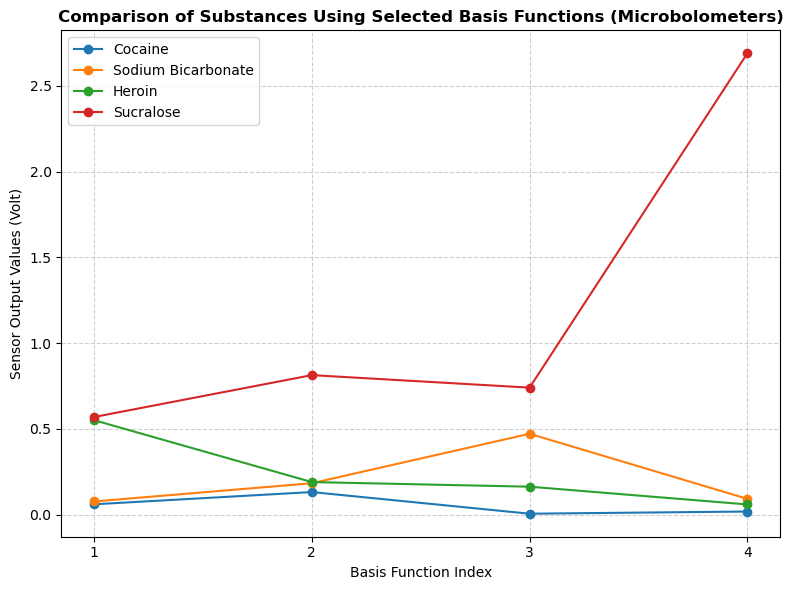

In [ ]:
# Retrieve the indices of the best subset
selected_subset_indices = list(best_result_mean_min["subset"])

# Retrieve the basis functions corresponding to the best subset
selected_basis_funcs = gaussian_basis_functions[:, selected_subset_indices]

# Generate the A matrix using the best subset of basis functions
sensor_outputs = simulate_sensor_output(
    wavelengths=wavelengths,
    substances_emissivity=emissivity_curves,
    basis_functions=selected_basis_funcs,
    temperature_K=temperature_K,
    atmospheric_distance_ratio=atmospheric_distance_ratio,
    air_refractive_index=air_refractive_index,
    air_transmittance=air_transmittance
)


visualize_sensor_output(sensor_outputs, substance_names)

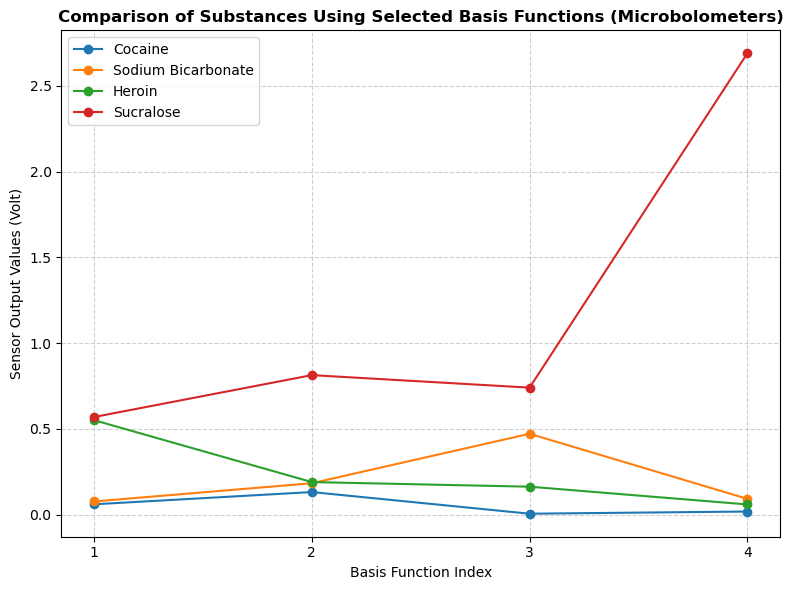

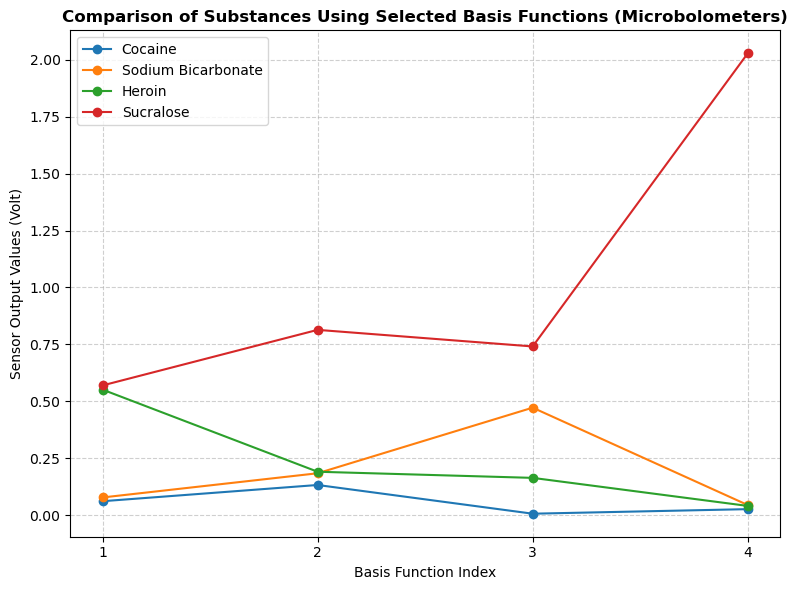

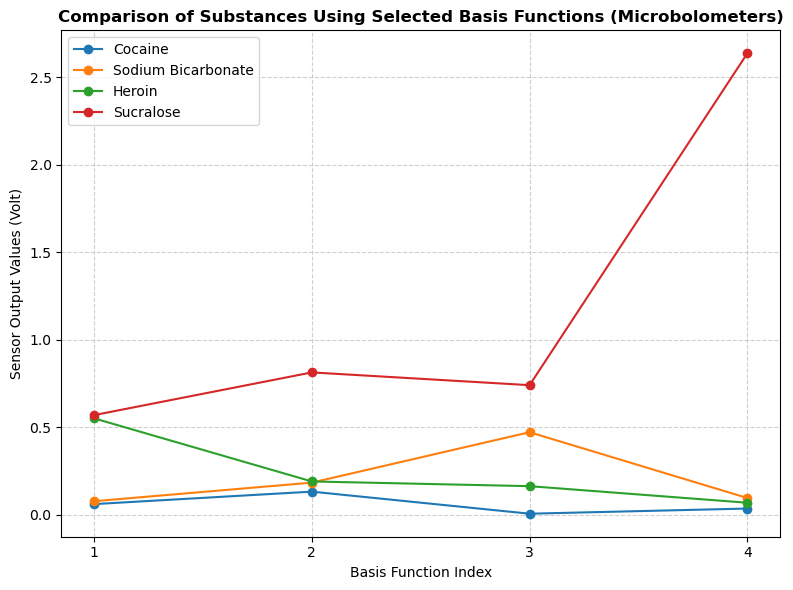

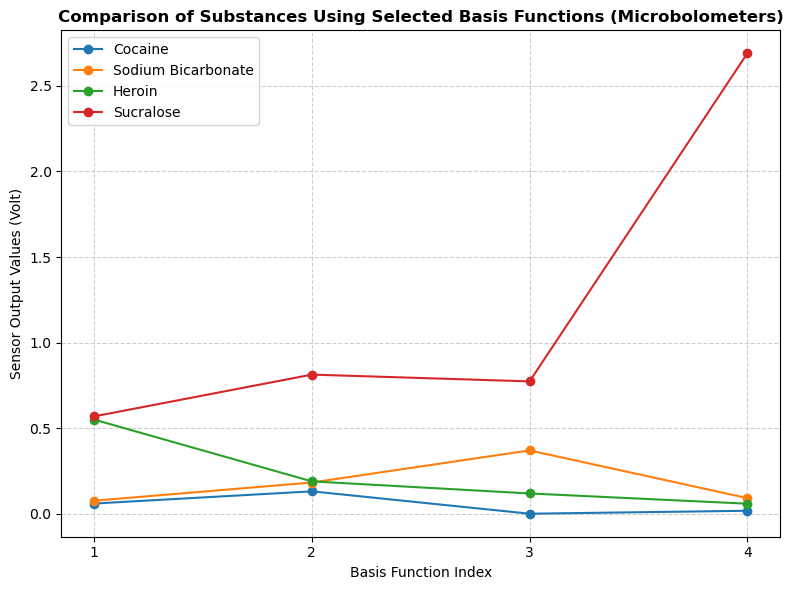

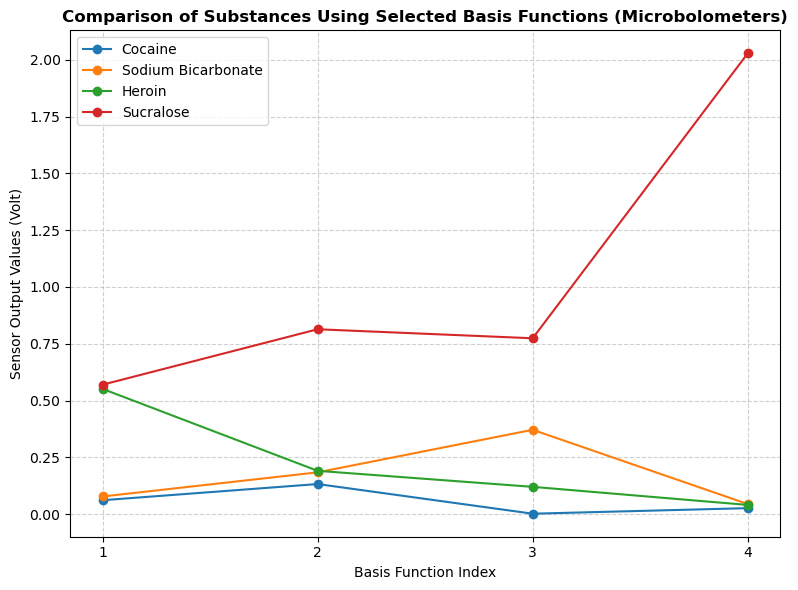

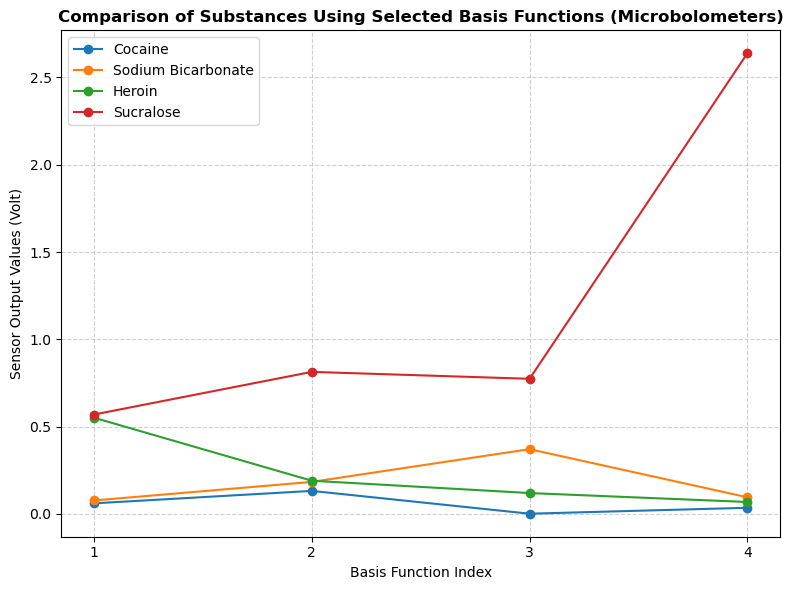

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sort results by score in descending order
top_results = results_df.sort_values(by="mean_min_score", ascending=False).head(6)

# Loop through the first 6 best subsets
for idx, row in top_results.iterrows():
    subset_indices = list(row["subset"])  # Get the indices of the current subset
    selected_basis_funcs = gaussian_basis_functions[:, subset_indices]  # Retrieve the basis functions

    # Generate the A matrix using the selected basis functions
    sensor_outputs = simulate_sensor_output(
        wavelengths=wavelengths,
        substances_emissivity=emissivity_curves,
        basis_functions=selected_basis_funcs,
        temperature_K=temperature_K,
        atmospheric_distance_ratio=atmospheric_distance_ratio,
        air_refractive_index=air_refractive_index,
        air_transmittance=air_transmittance
    )

    visualize_sensor_output(sensor_outputs, substance_names)

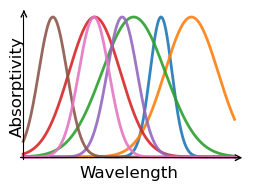

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values (from 4 to 20)
x = np.linspace(4, 20, 1000)

# # Randomly generate means and sigmas for the Gaussian curves
# # Generate and log a random seed
# seed = np.random.randint(0, 10000)
# print(f"Random Seed Used: {seed}")
# # Set the seed
# np.random.seed(seed)

np.random.seed(6905)

means = np.random.uniform(6, 18, size=7)  # Random means between 6 and 18
sigmas = np.random.uniform(0.5, 3.0, size=7)  # Larger variance for sigmas (0.5 to 3.0)

# Generate Gaussian-like basis functions
gaussian_basis_functions_demo = [np.exp(-((x - mu)**2) / (2 * sigma**2)) for mu, sigma in zip(means, sigmas)]

# Create a color scheme from Matplotlib's 'tab10' for distinct colors
colors = plt.cm.tab10.colors  # 10 distinct, vibrant colors

# Plot all basis functions
plt.figure(figsize=(3, 2))
for i, bf in enumerate(gaussian_basis_functions_demo):
    plt.plot(x, bf, color=colors[i % len(colors)], linewidth=2, alpha=0.9)  # Cycle through tab10 colors

# Add traditional x and y axes with arrows
plt.axhline(0, color='black', linewidth=0.8, xmin=0.03, xmax=0.97)  # x-axis
plt.axvline(4, color='black', linewidth=0.8, ymin=0.03, ymax=0.97)  # y-axis

# Add arrowheads for axes
plt.annotate('', xy=(20.8, -0.005), xytext=(19.8, -0.005), arrowprops=dict(arrowstyle="->", color='black'))
plt.annotate('', xy=(4.05, 1.05), xytext=(4.05, 1.02), arrowprops=dict(arrowstyle="->", color='black'))

# Add centered axis labels
plt.text(12, -0.15, 'Wavelength', fontsize=12, ha='center')  # Centered along the x-axis
plt.text(3, 0.5, 'Absorptivity', fontsize=12, va='center', rotation='vertical')  # Centered along the y-axis

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Remove ticks
plt.xticks([])  # No tick marks for x-axis
plt.yticks([])  # No tick marks for y-axis

# Add a title
# plt.title("Arbitrary Basis Functions", fontsize=16)

# Save the plot as an image
# plt.savefig("arbitrary_basis_function_generator_high_variance.png", dpi=300, bbox_inches='tight')
plt.show()

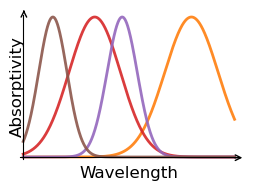

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
seed = 6905
np.random.seed(seed)

# Generate x values (from 4 to 20)
x = np.linspace(4, 20, 1000)

# Generate means and sigmas for the 7 basis functions
means = np.random.uniform(6, 18, size=7)  # Random means between 6 and 18
sigmas = np.random.uniform(0.5, 3.0, size=7)  # Larger variance for sigmas (0.5 to 3.0)

# Generate Gaussian-like basis functions
gaussian_basis_functions_demo = [np.exp(-((x - mu)**2) / (2 * sigma**2)) for mu, sigma in zip(means, sigmas)]

# Select a subset of 4 basis functions
selected_indices = [1, 3, 4, 5]  # Customize indices for the subset

# Create a color scheme for all 7 basis functions
colors = plt.cm.tab10.colors  # Vibrant colors from 'tab10'

# Plot the selected subset of basis functions, using the same colors
plt.figure(figsize=(3, 2))
for i in selected_indices:
    plt.plot(x, gaussian_basis_functions_demo[i], color=colors[i % len(colors)], linewidth=2, alpha=0.9)  # Use the same color for each index

# Add traditional x and y axes with arrows
plt.axhline(0, color='black', linewidth=0.8, xmin=0.03, xmax=0.97)  # x-axis
plt.axvline(4, color='black', linewidth=0.8, ymin=0.03, ymax=0.97)  # y-axis

# Add arrowheads for axes
plt.annotate('', xy=(20.8, -0.005), xytext=(19.8, -0.005), arrowprops=dict(arrowstyle="->", color='black'))
plt.annotate('', xy=(4.05, 1.05), xytext=(4.05, 1.02), arrowprops=dict(arrowstyle="->", color='black'))

# Add centered axis labels
plt.text(12, -0.15, 'Wavelength', fontsize=12, ha='center')  # Centered along the x-axis
plt.text(3, 0.5, 'Absorptivity', fontsize=12, va='center', rotation='vertical')  # Centered along the y-axis

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Remove ticks
plt.xticks([])  # No tick marks for x-axis
plt.yticks([])  # No tick marks for y-axis

# Add a title
# plt.title("Subset of 4 Basis Functions", fontsize=16)

# Save the plot as an image
# plt.savefig("subset_of_basis_functions_same_colors.png", dpi=300, bbox_inches='tight')
plt.show()

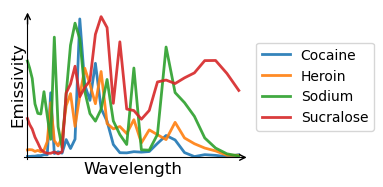

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

substance_names[2] = "Sodium"

# Ensure spectra is converted to a NumPy array
spectra_array = wavelengths.to_numpy().flatten()  # Flatten to 1D array for plotting

# Subsample the data (e.g., every 2nd point)
spectra_array = spectra_array[::4]  # Subsample spectra
substances_emissivity_subsampled = emissivity_curves[::4, :]  # Subsample emissivity data

# Create a color scheme for all substances
colors = plt.cm.tab10.colors  # Vibrant colors from 'tab10'

# Plot substances emissivity spectra in "illustration" style
plt.figure(figsize=(3, 2))

# Plot each substance emissivity curve
for i in range(len(substance_names)):
    plt.plot(
        spectra_array, 
        substances_emissivity_subsampled[:, i], 
        color=colors[i % len(colors)], 
        linewidth=2, 
        alpha=0.9, 
        label=substance_names[i]  # Add substance names to the legend
    )

# Add traditional x and y axes with arrows
plt.axhline(0, color='black', linewidth=0.8, xmin=0.03, xmax=0.97)  # x-axis
plt.axvline(spectra_array.min(), color='black', linewidth=0.8, ymin=0.03, ymax=0.97)  # y-axis

# Add arrowheads for axes
plt.annotate('', xy=(spectra_array.max()+0.8, -0.005), xytext=(spectra_array.max(), -0.005), arrowprops=dict(arrowstyle="->", color='black'))
plt.annotate('', xy=(spectra_array.min()+0.01, 1.02), xytext=(spectra_array.min()+0.01, 0.9), arrowprops=dict(arrowstyle="->", color='black'))

# Add centered axis labels
plt.text(spectra_array.mean()+2, -0.12, 'Wavelength', fontsize=12, ha='center')  # Centered along the x-axis
plt.text(spectra_array.min() - 1.3, 0.5, 'Emissivity', fontsize=12, va='center', rotation='vertical')  # Centered along the y-axis

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Remove ticks
plt.xticks([])  # No tick marks for x-axis
plt.yticks([])  # No tick marks for y-axis

# Add a title
# plt.title("Substances Emissivity Spectra", fontsize=16)

# Add a legend on the right side
plt.legend(
    loc='center left', 
    bbox_to_anchor=(1, 0.5), 
    fontsize=10
)

# Save the plot as an image
# plt.savefig("substances_emissivity_spectra_with_legend.png", dpi=300, bbox_inches='tight')
plt.show()

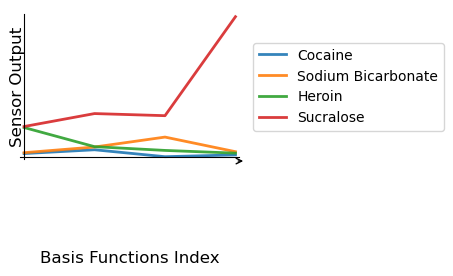

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure A_matrix is converted to a NumPy array
sensor_outputs = np.array(sensor_outputs)  # Ensure it's a NumPy array if not already

# Create a color scheme for all substances
colors = plt.cm.tab10.colors  # Vibrant colors from 'tab10'

# Plot sensor output in "illustration" style
plt.figure(figsize=(3, 2))

# Plot each substance's sensor output curve
for i in range(sensor_outputs.shape[1]):  # Iterate over substances (columns of A_matrix)
    plt.plot(
        range(1, sensor_outputs.shape[0] + 1),  # Basis function indices (x-axis)
        sensor_outputs[:, i],  # Sensor output values (y-axis)
        color=colors[i % len(colors)], 
        linewidth=2, 
        alpha=0.9, 
        label=substance_names[i]  # Add substance names to the legend
    )

# Add traditional x and y axes with arrows
plt.axhline(0, color='black', linewidth=0.8, xmin=0.03, xmax=0.97)  # x-axis
plt.axvline(1, color='black', linewidth=0.8, ymin=0.03, ymax=0.97)  # y-axis

# Add arrowheads for axes
plt.annotate('', xy=(sensor_outputs.shape[0] + 0.15, -0.08), xytext=(sensor_outputs.shape[0], -0.08), arrowprops=dict(arrowstyle="->", color='black'))
plt.annotate('', xy=(1.01, sensor_outputs.max() + 0.5), xytext=(1.01, sensor_outputs.max() + 0.25), arrowprops=dict(arrowstyle="->", color='black'))

# Add centered axis labels
plt.text(sensor_outputs.shape[0] / 2 + 0.5, -2, 'Basis Functions Index', fontsize=12, ha='center')  # Centered along the x-axis
plt.text(0.8, sensor_outputs.max() / 2, 'Sensor Output', fontsize=12, va='center', rotation='vertical')  # Centered along the y-axis

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Remove ticks
plt.xticks([])  # No tick marks for x-axis
plt.yticks([])  # No tick marks for y-axis

# Add a title
# plt.title("Sensor Outputs for Substances", fontsize=16)

# Add a legend on the right side
plt.legend(
    loc='center left', 
    bbox_to_anchor=(1, 0.5), 
    fontsize=10
)

# Save the plot as an image
# plt.savefig("sensor_outputs_substances_illustration.png", dpi=300, bbox_inches='tight')
plt.show()

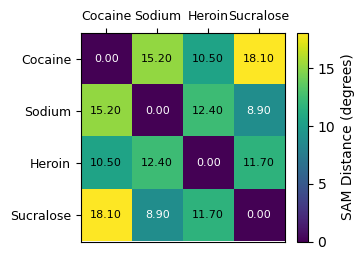

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Format labels to break into multiple lines if they have more than one word
substance_names = ["Cocaine", "Sodium", "Heroin", "Sucralose"]
labels = ["\n".join(label.split()) for label in substance_names]  # Split by spaces and rejoin with newlines

# Example distance matrix (4x4 for simplicity)
distance_matrix = np.array([
    [0.0, 15.2, 10.5, 18.1],
    [15.2, 0.0, 12.4, 8.9],
    [10.5, 12.4, 0.0, 11.7],
    [18.1, 8.9, 11.7, 0.0]
])

# Set the figure size
plt.figure(figsize=(3.7, 2.7))
ax = plt.gca()  # Get current axis
img = plt.imshow(distance_matrix, cmap="viridis", aspect='auto')

# Add a colorbar
cbar = plt.colorbar(img)
cbar.set_label("SAM Distance (degrees)", fontsize=10)

# Add labels
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, fontsize=9)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels, fontsize=9)

# Move x-axis labels to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Add cell values (distances)
for i in range(distance_matrix.shape[0]):
    for j in range(distance_matrix.shape[1]):
        plt.text(
            j, i, f"{distance_matrix[i, j]:.2f}",
            ha='center', va='center',
            fontsize=8, color="black" if distance_matrix[i, j] > (distance_matrix.max() / 2) else "white"
        )

# Set title
# plt.title("Distance Matrix (SAM)", fontsize=12, pad=10)

plt.tight_layout()
plt.show()

In [ ]:
# # Sample 1/3 of the data for plotting
# results_df_sampled = results_df_sorted.iloc[::3]  # Select every third row

# # Create a smaller illustrative bar plot
# plt.figure(figsize=(3.2, 3))  # Adjust the figure size for a smaller plot
# plt.bar(range(len(results_df_sampled)), results_df_sampled["score"], color='skyblue')
# plt.xlabel("Ranked Basis Function Conbinations", fontsize=10)
# plt.ylabel("SAM Based Score", fontsize=10)
# # plt.title("Ranked Differentiability Scores for Sensor Configurations", fontsize=12)
# plt.xticks(
#     ticks=range(len(results_df_sampled)),
#     labels=[str(sub) for sub in results_df_sampled["subset"]],
#     rotation=90,
#     fontsize=10
# )
# plt.tight_layout()
# plt.show()